## <ins style = "color : orange">A Unified Framework for Structured Graph Learning via Spectral Constraints</ins>

This here is the implementaion of: A Unified Framework for Structured Graph Learning via Spectral Constraints by: Sandeep Kumar, Jiaxi Ying, José Vinícius de M. Cardoso, Daniel P. Palomar. This is work was done by: Iliass Khoutaibi and Rayane Baraka.

You may notice two distinct parts in terms of implementation and code style. This is because each student wrote their own parts.

We have two important parts: The SGL part written by Iliass Khoutaibi and the SGA part written by Rayane Baraka.

please install the required libraries before executing the code.

In [87]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


We first import useful libraries to be used throughout the report.

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import scipy as sp
import networkx as nx
import pandas as pd
import seaborn as sns
import folium
import geopandas as gpd
import contextily as cx
from scipy.spatial.distance import pdist, squareform
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.linalg import eigh

### Helper Functions

Here have some helper functions to calulcate the adjacency matrix from the Laplacian matrix and vice-versa.

In [89]:
def edge_list(p: int):
    """
    Returns list of (i,j) pairs with i>j in a fixed order.
    Length = p*(p-1)//2
    """
    edges = []
    for j in range(p):
        for i in range(j+1, p):
            edges.append((i, j))

    edges = np.array(edges)
    return edges

def adjacency_from_theta(Theta: np.ndarray, thr_quantile: float = 0.90) -> np.ndarray:
    """
    Recover adjacency matrix W from Laplacian Theta.
    Threshold by quantile on positive weights.
    """
    # off-diagonal weights
    W = np.maximum(-Theta, 0.0)
    np.fill_diagonal(W, 0.0)

    # threshold (to visualize / binarize structure)
    positive = W[W > 0]
    if positive.size == 0:
        return W

    thr = np.quantile(positive, thr_quantile)
    print(f"[adjacency_from_theta] threshold = {thr:.4g}")

    W[W < thr] = 0.0
    return W

def laplacian_from_W(W: np.ndarray):
    """ Laplacian L = D - W.
    
        W : Adjacency matrix of the graph 
    """
    D = np.diag(W.sum(axis=1))
    return D - W

def normalized_laplacian_from_W(W: np.ndarray):

    """Normalized Laplacian L_sym = I - D^{-1/2} W D^{-1/2}."""
    
    d = W.sum(axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))

    I = np.eye(W.shape[0])
    # Formula in tp altegrad
    return I - D_inv_sqrt @ W @ D_inv_sqrt

### Performance metrics

We use two standard metrics to evaluate the performance of our algorithms.

The **F1 score** measures the quality of edge recovery by balancing precision and recall:
$$
\mathrm{F1} = \frac{2 \cdot \text{precision} \cdot \text{recall}}
{\text{precision} + \text{recall}} .
$$

The **relative error** quantifies the discrepancy between an estimated matrix $\widehat{X}$ and the ground truth $X$:
$$
\mathrm{RelErr} = \frac{\|\widehat{X} - X\|_F}{\|X\|_F} .
$$


In [90]:
def count_components_from_eigs(eigs, tol=1e-8):
    """#components = multiplicity of eigenvalue 0 (within tolerance)."""
    return int(np.sum(eigs < tol))

def evaluate_graph_performance(W_true, W_learned, threshold=1e-5):
    """
    Computes the Relative Error (RE) and F-score (FS) as defined in the reference paper.

    Args:
        W_true (np.array): Ground-truth adjacency matrix.
        W_learned (np.array): Adjacency matrix learned by the algorithm.
        threshold (float): Values below this threshold are treated as zero-weight edges.

    Returns:
        dict: {'RE': float, 'FS': float}
    """
    # Upper triangular extraction for symmetric matrices
    p = W_true.shape[0]
    iu = np.triu_indices(p, k=1)
    
    w_true_vec = W_true[iu]
    w_learned_vec = W_learned[iu]
    
    # Relative Error on continuous edge weights
    diff_norm = np.linalg.norm(w_learned_vec - w_true_vec)
    true_norm = np.linalg.norm(w_true_vec)
    
    if true_norm == 0:
        re = 0.0 if diff_norm == 0 else np.inf
    else:
        re = diff_norm / true_norm

    # F-score based on binary edge recovery
    bin_true = (np.abs(w_true_vec) > threshold).astype(int)
    bin_learned = (np.abs(w_learned_vec) > threshold).astype(int)
    
    # True positives, false positives, and false negatives
    tp = np.sum((bin_true == 1) & (bin_learned == 1))
    fp = np.sum((bin_true == 0) & (bin_learned == 1))
    fn = np.sum((bin_true == 1) & (bin_learned == 0))
    
    denom = 2 * tp + fp + fn
    if denom == 0:
        fs = 1.0
    else:
        fs = (2 * tp) / denom

    return {"RE": re, "FS": fs}

# SGL Algorithm, Iliass' part.

### Laplacian operator $\mathcal{L}$ and adjoint $\mathcal{L}^\star$

Let $w \in \mathbb{R}^{m}$ with $m = \frac{p(p-1)}{2}$ be the vector of edge weights of an undirected graph.

The operator  

$$
\mathcal{L} : \mathbb{R}^{m} \to \mathbb{S}^{p}
$$

maps $w$ to the graph Laplacian $L = \mathcal{L}(w)$ defined by

$$
L_{ij} =
\begin{cases}
- w_{ij}, & i \neq j, \\
\sum_{k \neq i} w_{ik}, & i = j .
\end{cases}
$$

The adjoint operator  

$$
\mathcal{L}^\star : \mathbb{S}^{p} \to \mathbb{R}^{m}
$$
satisfies

$$
\langle \mathcal{L}(w), X \rangle = \langle w, \mathcal{L}^\star(X) \rangle ,
$$

and is given componentwise by

$$
(\mathcal{L}^\star(X))_{ij} = X_{ii} + X_{jj} - 2X_{ij}, \quad i < j .
$$



In [91]:
def L_operator(w: np.ndarray, p: int, edges=None) -> np.ndarray:
    """
    Laplacian operator L: 
    Builds Theta = Lw such that:
      Theta_ij = -w_k for (i,j) edge with i>j
      Theta is symmetric
      Theta_ii = -sum_{j!=i} Theta_ij  (so rows sum to 0)
    Matches Definition of Laplacian set S_Theta and operator L.  (paper Sec 3.1)

    See the paper for more information, specifically [page 13] !
    """

    if edges is None:
        edges = edge_list(p)
    m = p * (p - 1) // 2
    assert w.shape == (m,), f"w must have shape ({m},), got {w.shape}"

    Theta = np.zeros((p, p))
    for k, (i, j) in enumerate(edges):

        Theta[i, j] = -w[k]
        Theta[j, i] = -w[k]

    Theta[np.diag_indices(p)] = -Theta.sum(axis=1)

    return Theta

def L_adjoint(Y: np.ndarray, p: int, edges=None) -> np.ndarray:

    """
    Adjoint operator L*: 
    For each edge (i>j), returns:
      [L*Y]_k = Y_ii - Y_ij - Y_ji + Y_jj

    See paper for adjoint formula, specifically [page 14]
    """

    if edges is None:
        edges = edge_list(p)

    assert Y.shape == (p, p), f"Y must have shape ({p},{p}), got {Y.shape}"

    m = p * (p - 1) // 2
    out = np.zeros(m)

    for k, (i, j) in enumerate(edges):
        out[k] = Y[i, i] - Y[i, j] - Y[j, i] + Y[j, j]

    return out

We test the correctness of the adjoint operator by comparing the inner products
$$
\langle \mathcal{L}(w), X \rangle_F
\quad \text{and} \quad
\langle w, \mathcal{L}^\star(X) \rangle ,
$$
where
$$
\langle A, B \rangle_F = \mathrm{Tr}(A^\top B)
\quad \text{and} \quad
\langle u, v \rangle = u^\top v .
$$

In [92]:
p = 100
edges = edge_list(p)

m = p*(p-1)//2
w = np.arange(1, m+1)
Theta = L_operator(w, p, edges)
Y = np.random.randn(p, p)

left = np.sum(Theta * Y)  
right = np.dot(w, L_adjoint(Y, p, edges))
print("adjoint error:", np.isclose(left - right, 0), np.abs(left - right))

adjoint error: True 0.0


We can verify that the scalar product is preserved, which confirms that the adjoint formula is correct.

This part plots the connected components of the graph and displays the Laplacian eigenvalues. The number of zero eigenvalues corresponds to the number of connected components.

Connected components (networkx): 3
Connected components (spectral): 3
Smallest eigenvalues: [-2.38697950e-15 -2.95270709e-16  7.52265546e-15  1.48586987e+00
  1.73521057e+00  1.77836022e+00  2.39494478e+00  2.56863399e+00
  2.82904193e+00  2.89995912e+00]


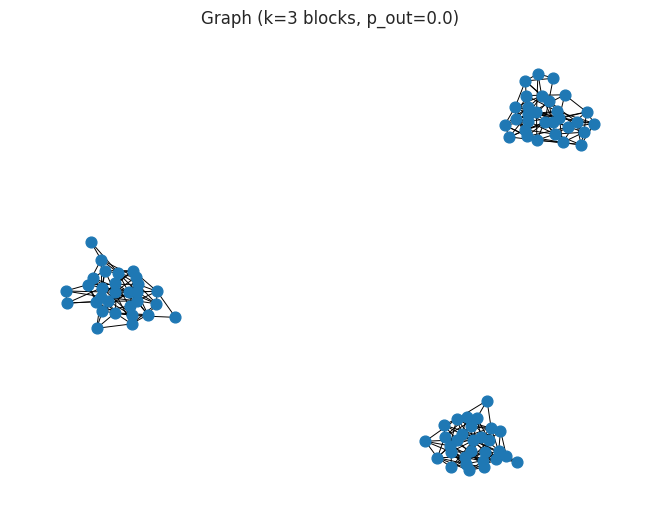

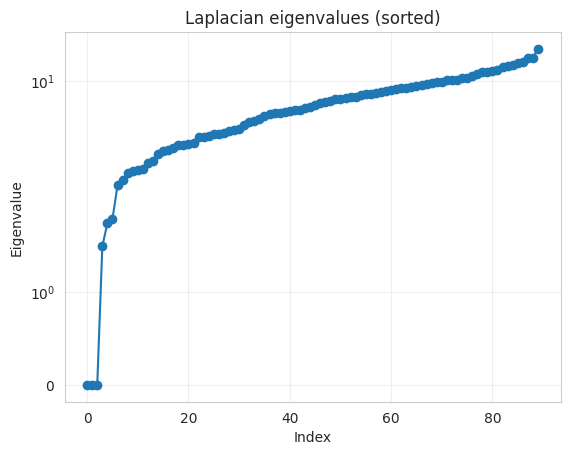

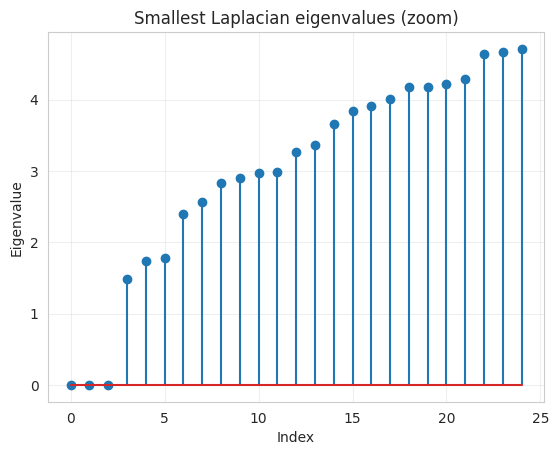

In [93]:
# -----------------------------
# Generate a graph with k connected components
# -----------------------------
n_per = 30
k = 3
p_in = 0.25   
p_out = 0.0   

sizes = [n_per] * k
P = np.full((k, k), p_out)
np.fill_diagonal(P, p_in)

G = nx.stochastic_block_model(sizes, P)
W = nx.to_numpy_array(G, weight=None)
np.fill_diagonal(W, 0.0)

# -----------------------------
# Laplacian and eigenvalues
# -----------------------------
L = laplacian_from_W(W) 

eigs = np.linalg.eigvalsh(L)  
num_cc = nx.number_connected_components(G)
num_cc_from_spec = count_components_from_eigs(eigs, tol=1e-8)

print("Connected components (networkx):", num_cc)
print("Connected components (spectral):", num_cc_from_spec)
print("Smallest eigenvalues:", eigs[:10])

# -----------------------------
# Plot graph and eigenvalues
# -----------------------------
plt.figure()
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=60, width=0.7)
plt.title(f"Graph (k={k} blocks, p_out={p_out})")
plt.axis("off")
plt.show()

plt.figure()
plt.plot(eigs, marker="o")
plt.yscale("symlog")  
plt.title("Laplacian eigenvalues (sorted)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
m = min(25, len(eigs))
plt.stem(range(m), eigs[:m])
plt.title("Smallest Laplacian eigenvalues (zoom)")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True, alpha=0.3)
plt.show()


### Sampling and empirical covariance

We generate samples from an intrinsic Gaussian Markov random field (IGMRF) by using the pseudo-inverse of the precision matrix $\Theta$. Since $\Theta$ may be singular, the covariance matrix is defined as
$$
\Sigma = \Theta^{\dagger},
$$
where $\dagger$ denotes the Moore–Penrose pseudo-inverse. We then draw $n$ samples from the multivariate normal distribution
$$
X \sim \mathcal{N}(0, \Sigma).
$$

Given a data matrix $X \in \mathbb{R}^{n \times p}$, we compute the centered empirical covariance matrix as
$$
S = \frac{1}{n} X_c^\top X_c,
\qquad
X_c = X - \mathbb{\hat{E}}[X],
$$
which matches the definition used in the paper.

In [94]:
def sample_igmrf(Theta: np.ndarray, n: int, rng=None):
    """
    Uses pseudo-inverse covariance.
    """
    if rng is None:
        rng = np.random.default_rng(0)
    Sigma = np.linalg.pinv(Theta)
    X = rng.multivariate_normal(mean=np.zeros(Theta.shape[0]), cov=Sigma, size=n)
    return X

def sample_covariance(X: np.ndarray):
    # matches (67) in the paper: centered sample covariance :contentReference[oaicite:6]{index=6}
    Xc = X - X.mean(axis=0, keepdims=True)
    return (Xc.T @ Xc) / Xc.shape[0]

### SGL Algorithm
First we define the SGL algorithm's objective function.

In [95]:
def sgl_objective(S: np.ndarray,
                  Lw: np.ndarray,
                  w: np.ndarray,
                  U: np.ndarray,
                  lam: np.ndarray,
                  alpha: float,
                  beta: float,
                  eps: float,
                  phi) -> float:
    """
    F(w,lam,U) =
      - log gdet(Diag(lam)) + tr(S Lw) + alpha * sum_i phi(w_i)
      + (beta/2) * ||Lw - U Diag(lam) U^T||_F^2
    """
    lam = np.asarray(lam, dtype=float)
    if np.any(lam <= 0):
        return np.inf  

    term_gdet = -np.sum(np.log(lam))                 
    term_trace = float(np.trace(S @ Lw))             
    term_sparse = float(alpha * np.sum(phi(w, eps)))      

    B = U @ np.diag(lam) @ U.T
    term_pen = 0.5 * beta * (np.linalg.norm(Lw - B, ord="fro") ** 2)

    return term_gdet + term_trace + term_sparse + term_pen

Since we are doing gradient descent. The paper suggests initialiing the weights from similarity matrix S.

In [96]:
def w_init_naive_from_S(S: np.ndarray, edges: np.ndarray) -> np.ndarray:
    """
    Repo's 'naive' init: w_ij = max(0, -pinv(S)_{ij})
    """
    Sinv = np.linalg.pinv(S)
    m = len(edges)
    w0 = np.zeros(m, dtype=float)
    for e, (i, j) in enumerate(edges):
        w0[e] = max(-Sinv[i, j], 0.0)
    # small epsilon to avoid degenerate Lw at start (optional)
    w0 += 1e-12
    return w0

In the following cells we define the ways to update the parameteres of the SGL model.

In [97]:
def U_update(Lw: np.ndarray, k: int):
    evals, evecs = np.linalg.eigh(Lw)
    return evecs[:, k:], evals

In [98]:
def lambda_update_closed_form(d: np.ndarray, beta: float, c1: float, c2: float):
    d = np.asarray(d, dtype=float)
    lam = 0.5 * (d + np.sqrt(d*d + 4.0/beta))
    lam = np.clip(lam, c1, c2)

    # lambda must be nondecreasing
    if np.any(np.diff(lam) < -1e-9):
        raise ValueError("lambda not nondecreasing; increase beta.")
    return lam

In [99]:
def apply_M(v: np.ndarray, p: int, edges: np.ndarray) -> np.ndarray:
    """
    M v = L*(L(v)), where L(v) is a Laplacian built from weight-vector v.
    """
    Lv = L_operator(v, p, edges)
    return L_adjoint(Lv, p, edges)

In [100]:
def w_update(w: np.ndarray, Lw: np.ndarray, U: np.ndarray, lam: np.ndarray,
                        beta: float, K: np.ndarray, p: int, edges: np.ndarray) -> np.ndarray:
    """
    Mirrors R's laplacian.w_update:
      c = L*(U diag(lam) U^T - K/beta)
      grad_f = L*(Lw) - c
      t = (w^T M grad_f - c^T grad_f) / (grad_f^T M grad_f)
      w <- (w - t grad_f)_+
    """
    ULmdUT = U @ np.diag(lam) @ U.T
    c = L_adjoint(ULmdUT - (K / beta), p, edges)

    grad_f = L_adjoint(Lw, p, edges) - c
    M_grad_f = apply_M(grad_f, p, edges)

    denom = float(np.dot(grad_f, M_grad_f))
    if denom <= 1e-18 or not np.isfinite(denom):
        return np.maximum(w, 0.0)

    numer = float(np.dot(w, M_grad_f) - np.dot(c, grad_f))
    t = numer / denom

    w_new = np.maximum(w - t * grad_f, 0.0)
    return w_new

We implement both the $\ell_1$ regularized SGL algorithm and the log-barrier approach.

In [101]:
def sgl_paper_style(S: np.ndarray,
                k: int,
                beta: float = 400.0,
                alpha: float = 0.1,
                eps: float = 1e-4,
                c1: float = 1e-9,
                c2: float = 1e9,
                maxiter: int = 200,
                reltol: float = 1e-6,
                w0: np.ndarray | None = None,
                verbose: bool = True):

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    edges = edge_list(p)
    m = len(edges)

    # ---- init w ----
    if w0 is None:
        w = w_init_naive_from_S(S, edges)   # IMPORTANT
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    # H and K (reweighted l1 surrogate) like repo
    H = alpha * (2 * np.eye(p) - np.ones((p, p)))

    # initial Lw, U, lam
    Lw = L_operator(w, p, edges)
    U, evals = U_update(Lw, k)
    d = np.diag(U.T @ Lw @ U)
    lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

    # K update (safe division)
    denom = (-Lw + eps)
    K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)

    hist = {"relchg_w": [], "penalty": [], "eig_k": [], "step": []}

    for it in range(maxiter):
        w_old = w.copy()

        # ----- w-update (repo style) -----
        w = w_update(w, Lw, U, lam, beta, K, p, edges)

        # ----- update Lw, U, lam -----
        Lw = L_operator(w, p, edges)
        U, evals = U_update(Lw, k)
        d = np.diag(U.T @ Lw @ U)
        lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

        # ----- update K (safe) -----
        # denom = (-Lw + eps)
        K = S + H

        # ----- logging / stopping -----
        relchg = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)
        hist["relchg_w"].append(relchg)
        hist["penalty"].append(np.linalg.norm(Lw - U @ np.diag(lam) @ U.T, ord="fro"))
        hist["eig_k"].append(evals[k] if k < len(evals) else np.nan)

        if verbose and (it % 10 == 0 or it == maxiter - 1):
            print(f"[it={it:03d}] relchg(w)={relchg:.3e}, eig[k]={hist['eig_k'][-1]:.3e}")

        if relchg < reltol:
            break

    return Lw, w, U, lam, hist

In [102]:
def sgl_log_barrier_style(S: np.ndarray,
                k: int,
                beta: float = 400.0,
                alpha: float = 0.1,
                eps: float = 1e-1,
                c1: float = 1e-9,
                c2: float = 1e9,
                maxiter: int = 200,
                reltol: float = 1e-6,
                w0: np.ndarray | None = None,
                verbose: bool = True):

    S = np.asarray(S, dtype=float)
    p = S.shape[0]
    edges = edge_list(p)
    m = len(edges)

    # ---- init w ----
    if w0 is None:
        w = w_init_naive_from_S(S, edges)   # IMPORTANT
    else:
        w = np.maximum(np.asarray(w0, dtype=float).copy(), 0.0)

    # H and K (reweighted l1 surrogate) like repo
    H = alpha * (2 * np.eye(p) - np.ones((p, p)))

    # initial Lw, U, lam
    Lw = L_operator(w, p, edges)
    U, evals = U_update(Lw, k)
    d = np.diag(U.T @ Lw @ U)
    lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

    # K update (safe division)
    denom = (-Lw + eps)
    K = S + np.divide(H, denom, out=np.zeros_like(H), where=np.abs(denom) > 0)  

    hist = {"relchg_w": [], "penalty": [], "eig_k": [], "step": []}

    for it in range(maxiter):
        w_old = w.copy()

        # ----- w-update (repo style) -----
        w = w_update(w, Lw, U, lam, beta, K, p, edges)

        # ----- update Lw, U, lam -----
        Lw = L_operator(w, p, edges)
        U, evals = U_update(Lw, k)
        d = np.diag(U.T @ Lw @ U)
        lam = lambda_update_closed_form(d, beta=beta, c1=c1, c2=c2)

        # ----- update K (safe) -----
        denom = (Lw + eps)
        H = (alpha / beta) * (1 / denom)
        K = S + H

        # ----- logging / stopping -----
        relchg = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-12)
        hist["relchg_w"].append(relchg)
        hist["penalty"].append(np.linalg.norm(Lw - U @ np.diag(lam) @ U.T, ord="fro"))
        hist["eig_k"].append(evals[k] if k < len(evals) else np.nan)

        if verbose and (it % 10 == 0 or it == maxiter - 1):
            print(f"[it={it:03d}] relchg(w)={relchg:.3e}, eig[k]={hist['eig_k'][-1]:.3e}")

        if relchg < reltol:
            break

    return Lw, w, U, lam, hist

### Application to noisy graphs with k-connected components.

In [103]:
def make_block_k_component_laplacian(p=64, k=4, w_low=0.0, w_high=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    sizes = [p // k] * k
    assert sum(sizes) == p

    W_true = np.zeros((p, p), dtype=float)
    start = 0
    for sz in sizes:
        idx = np.arange(start, start + sz)
        W = rng.uniform(w_low, w_high, size=(   sz, sz))
        W = 0.5 * (W + W.T)
        np.fill_diagonal(W, 0.0)
        W_true[np.ix_(idx, idx)] = W
        start += sz

    Theta_true = laplacian_from_W(W_true)
    return W_true, Theta_true

def make_er_noise_laplacian(p=64, p_edge=0.25, kappa=0.45, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    M = (rng.random((p, p)) < p_edge).astype(float)
    M = np.triu(M, 1)
    M = M + M.T

    W_er = rng.uniform(0.0, kappa, size=(p, p))
    W_er = 0.5 * (W_er + W_er.T)
    np.fill_diagonal(W_er, 0.0)
    W_er = M * W_er

    Theta_er = laplacian_from_W(W_er)
    return W_er, Theta_er


[it=000] relchg(w)=1.426e-02, eig[k]=2.085e+01
[it=010] relchg(w)=7.440e-03, eig[k]=1.889e+01


[it=020] relchg(w)=5.426e-03, eig[k]=1.769e+01
[it=030] relchg(w)=4.190e-03, eig[k]=1.712e+01
[it=040] relchg(w)=3.410e-03, eig[k]=1.663e+01
[it=050] relchg(w)=2.853e-03, eig[k]=1.625e+01
[it=060] relchg(w)=2.370e-03, eig[k]=1.597e+01
[it=070] relchg(w)=2.024e-03, eig[k]=1.576e+01
[it=080] relchg(w)=1.735e-03, eig[k]=1.564e+01
[it=090] relchg(w)=1.478e-03, eig[k]=1.555e+01
[it=100] relchg(w)=1.292e-03, eig[k]=1.547e+01
[it=110] relchg(w)=1.144e-03, eig[k]=1.540e+01
[it=120] relchg(w)=1.020e-03, eig[k]=1.534e+01
[it=130] relchg(w)=9.319e-04, eig[k]=1.529e+01
[it=140] relchg(w)=8.465e-04, eig[k]=1.525e+01
[it=150] relchg(w)=7.766e-04, eig[k]=1.522e+01
[it=160] relchg(w)=7.144e-04, eig[k]=1.519e+01
[it=170] relchg(w)=6.458e-04, eig[k]=1.516e+01
[it=180] relchg(w)=6.099e-04, eig[k]=1.513e+01
[it=190] relchg(w)=5.647e-04, eig[k]=1.511e+01
[it=200] relchg(w)=5.289e-04, eig[k]=1.509e+01
[it=210] relchg(w)=4.939e-04, eig[k]=1.507e+01
[it=220] relchg(w)=4.658e-04, eig[k]=1.505e+01
[it=230] relc

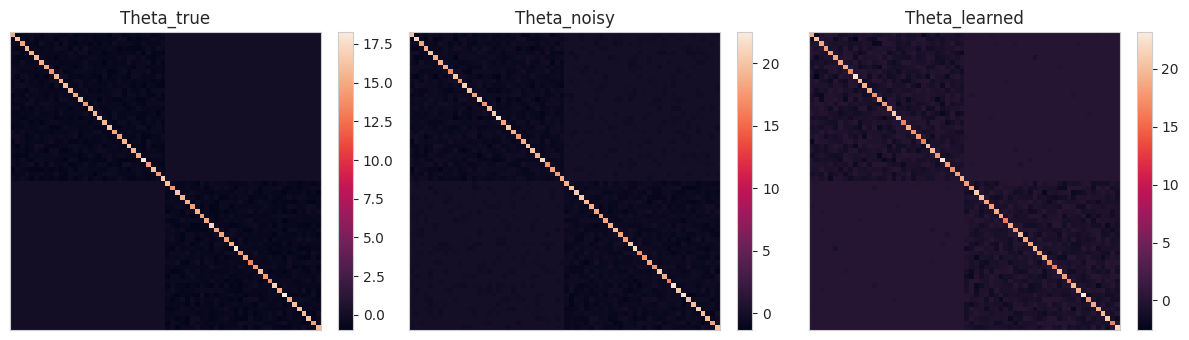

In [104]:
rng = np.random.default_rng(1)

p = 64
k_true = 2

# true multi-component Laplacian
W_true, Theta_true = make_block_k_component_laplacian(p=p, k=k_true, w_low=0.0, w_high=1.0, rng=rng)

# ER noise Laplacian (paper uses this corruption model)
W_er, Theta_er = make_er_noise_laplacian(p=p, p_edge=0.25, kappa=0.45, rng=rng)

Theta_noisy = Theta_true + Theta_er

# sample data from IGMRF and compute SCM (eq. 67)
n = 30 * p
X = sample_igmrf(Theta_noisy, n=n, rng=rng)
S = sample_covariance(X)

# run SGL (paper-like hyperparams for this scenario)
Theta_hat, w_hat, U_hat, lam_hat, hist = sgl_paper_style(
    S, k=k_true,
    beta=400.0, alpha=0.1, eps=1e-4,
    c1=1e-9, c2=1e9,
    maxiter=1000, reltol=1e-6,
    verbose=True
)

# metrics
edges = edge_list(p)
W_hat = adjacency_from_theta(Theta_hat)
results_dict = evaluate_graph_performance(W_learned=W_hat, W_true=W_true)
print(f"\nRE={results_dict['RE']:.3f}, F-score={results_dict['FS']:.3f}")

# plots: heatmaps like the paper
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for ax, M, title in zip(
    axes,
    [Theta_true, Theta_noisy, Theta_hat],
    ["Theta_true", "Theta_noisy", "Theta_learned"]
):
    im = ax.imshow(M, aspect="auto")
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046)
plt.tight_layout()
plt.show()


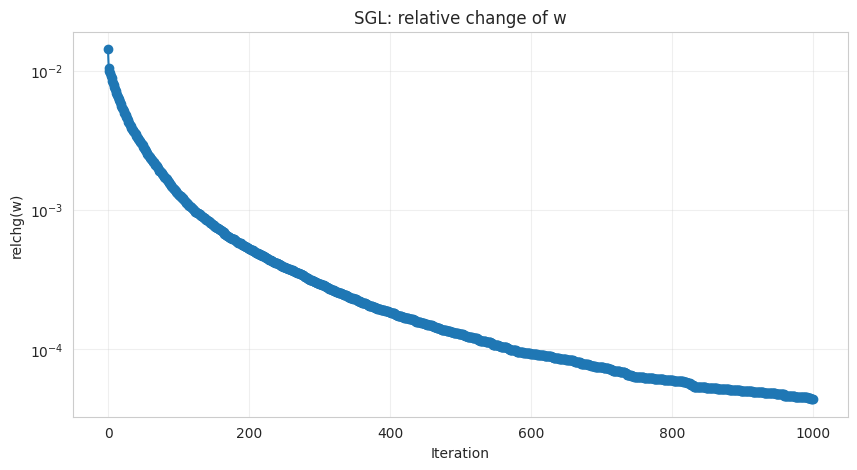

In [105]:
# convergence 
plt.figure(figsize=(10, 5))
plt.semilogy(hist["relchg_w"], marker="o")
plt.title("SGL: relative change of w")
plt.xlabel("Iteration")
plt.ylabel("relchg(w)")
plt.grid(True, alpha=0.3)
plt.show()

[adjacency_from_theta] threshold = 1.29


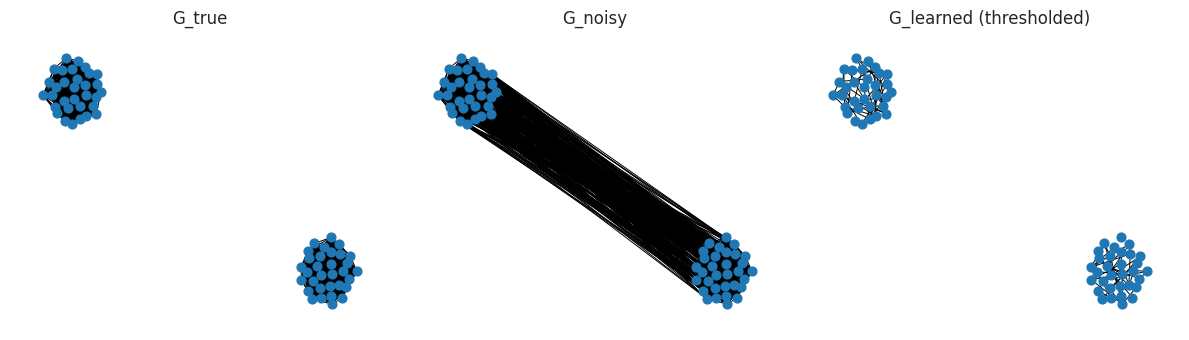

In [106]:
W_hat = adjacency_from_theta(Theta_hat, thr_quantile=0.90)

G_true = nx.from_numpy_array(np.maximum(W_true, 0.0))
G_noisy = nx.from_numpy_array(np.maximum(W_true + W_er, 0.0))
G_hat = nx.from_numpy_array(np.maximum(W_hat, 0.0))

pos = nx.spring_layout(G_true, seed=0)

plt.figure(figsize=(12, 3.5))

plt.subplot(1, 3, 1)
nx.draw(G_true, pos, node_size=40, width=0.7)
plt.title("G_true")
plt.axis("off")

plt.subplot(1, 3, 2)
nx.draw(G_noisy, pos, node_size=40, width=0.7)
plt.title("G_noisy")
plt.axis("off")

plt.subplot(1, 3, 3)
nx.draw(G_hat, pos, node_size=40, width=0.7)
plt.title("G_learned (thresholded)")
plt.axis("off")

plt.tight_layout()
plt.show()

### Evaluating the log-barrier and $\ell_1$-regularization.

We run multiple simulations on both algorithms with different noise intensities and look evaluate the relative errors / F_1 score for both methods. 

In [107]:
def run_monte_carlo_sensitivity_sgl(n_trials=15,
                                    p=32, n1=20, n2=12,
                                    n_samples=None,
                                    noise_levels=np.linspace(0.0, 1.0, 6),
                                    k=5, beta=400.0, alpha=0.1,
                                    maxiter=200,
                                    verbose=False):
    """
    Monte Carlo sensitivity analysis for SGL, comparing both
    log-barrier and paper-style SGL on the same dataset.
    
    Returns:
        df: raw trial results
        stats: aggregated statistics (mean, std, sem)
    """
    if n_samples is None:
        n_samples = p * 500

    methods = ["log_barrier", "paper"]
    res = []

    print(f"Monte Carlo SGL ({n_trials} trials per noise level)...")

    for kappa in noise_levels:
        print(f"\nNoise level kappa = {kappa:.2f}")
        for trial in range(n_trials):
            # --- 1. Generate Bipartite Ground Truth ---
            G_bi = nx.bipartite.random_graph(n1, n2, p=0.7)
            W_bi = nx.to_numpy_array(G_bi) * np.random.uniform(0.1, 1.0, (p, p))
            W_bi = (W_bi + W_bi.T) / 2
            L_true = np.diag(np.sum(W_bi, axis=1)) - W_bi  # Laplacian ground truth

            # --- 2. Add structural noise ---
            W_noise = nx.to_numpy_array(nx.erdos_renyi_graph(p, 0.35)) \
                      * np.random.uniform(0, kappa, (p, p))
            W_noise = (W_noise + W_noise.T) / 2
            L_noisy = np.diag(np.sum(W_bi + W_noise, axis=1)) - (W_bi + W_noise)

            # --- 3. Sample multivariate Gaussian ---
            Cov = np.linalg.pinv(L_noisy + 1e-6 * np.eye(p))
            X = np.random.multivariate_normal(np.zeros(p), Cov, n_samples)
            S = np.cov(X.T)

            # --- 4. Run both SGL methods ---
            for method in methods:
                if method == "log_barrier":
                    Lw, w, U, lam, hist = sgl_log_barrier_style(
                        S, k=k, beta=beta, alpha=alpha, maxiter=maxiter, verbose=verbose
                    )
                else:
                    Lw, w, U, lam, hist = sgl_paper_style(
                        S, k=k, beta=beta, alpha=alpha, maxiter=maxiter, verbose=verbose
                    )

                # --- 5. Evaluate performance using Laplacian ---
                eval_metrics = evaluate_graph_performance(L_true, Lw, threshold=0.05)

                res.append({
                    'kappa': kappa,
                    'trial': trial,
                    'method': method,
                    'RE': eval_metrics["RE"],
                    'FS': eval_metrics["FS"]
                })

    # --- Build DataFrame and statistics ---
    df = pd.DataFrame(res)
    stats = df.groupby(['kappa', 'method'])[['RE', 'FS']].agg(['mean', 'std', 'sem']).reset_index()

    print("\n--- Summary statistics (first rows) ---")
    print(stats.head())

    # --- Plotting both methods ---
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='kappa', y='RE', hue='method', marker='o', errorbar=('ci', 95))
    plt.title('Relative Error (RE) with 95% CI')
    plt.ylabel('RE')

    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x='kappa', y='FS', hue='method', marker='s', errorbar=('ci', 95))
    plt.title('F-score (FS) with 95% CI')
    plt.ylabel('FS')

    plt.tight_layout()
    plt.show()

    return df, stats

Monte Carlo SGL (10 trials per noise level)...

Noise level kappa = 0.00

Noise level kappa = 0.20

Noise level kappa = 0.40

Noise level kappa = 0.60

Noise level kappa = 0.80

Noise level kappa = 1.00

--- Summary statistics (first rows) ---
  kappa       method        RE                            FS            \
                          mean       std       sem      mean       std   
0   0.0  log_barrier  0.370777  0.018304  0.005788  0.858841  0.011201   
1   0.0        paper  0.370642  0.018507  0.005852  0.867141  0.009678   
2   0.2  log_barrier  0.406724  0.021173  0.006696  0.733657  0.018941   
3   0.2        paper  0.403663  0.021049  0.006656  0.743032  0.019588   
4   0.4  log_barrier  0.517538  0.016645  0.005264  0.690356  0.016964   

             
        sem  
0  0.003542  
1  0.003060  
2  0.005990  
3  0.006194  
4  0.005364  


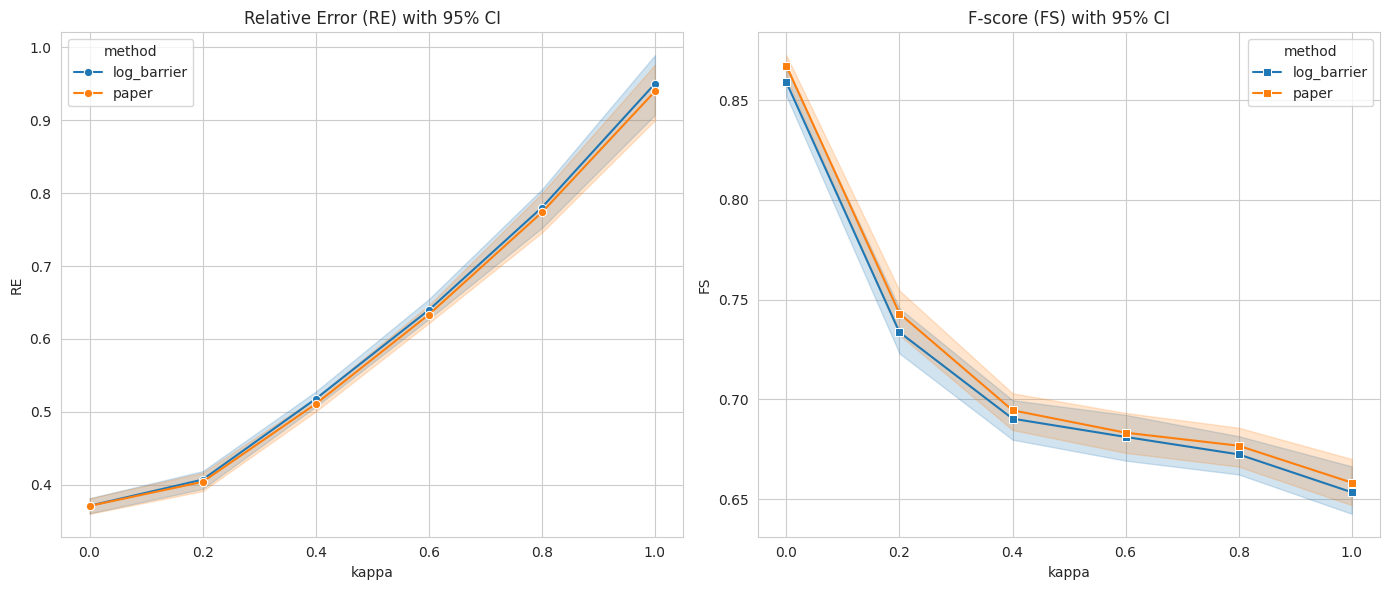

In [108]:
df_raw, df_stats = run_monte_carlo_sensitivity_sgl(n_trials=10)

We can see that the log-barrier methods yields similar results for this clustering task with the advantage of a smoother optimization approach.

### Paper experiment: The animal Dataset

In [109]:
A_animals = np.loadtxt("./AwA2-base/Animals_with_Attributes2/predicate-matrix-binary.txt")  
with open("./AwA2-base/Animals_with_Attributes2/classes.txt", "r") as f:
    class_names = [line.strip() for line in f]

In [110]:
A_animals = np.asarray(A_animals)
print("A_animals shape:", A_animals.shape)

# convention: rows=features, cols=animals? you used transpose so keep same
X_animals = A_animals.T

mu = X_animals.mean(axis=0, keepdims=True)

Xz = (X_animals - mu) 

S_animals = (Xz.T @ Xz) / Xz.shape[0]
p = S_animals.shape[0]
print("S_animals shape:", S_animals.shape)

# small diagonal loading (like you did)
S_in_animals = S_animals + (1/3) * np.eye(p)

A_animals shape: (50, 85)
S_animals shape: (50, 50)


In [111]:
Theta_hat_animals, w_hat, U_hat, lam_hat, hist = sgl_paper_style(
    S_in_animals,
    k=12,
    alpha=0.0,
    beta=0.5,
    eps=1e-3,
    c1=1e-3,
    c2=1e3,
    reltol=1e-5,
    maxiter=1000,
    verbose=True
)
W_hat_animals = adjacency_from_theta(Theta_hat_animals, thr_quantile=0.90)

[it=000] relchg(w)=1.611e-01, eig[k]=1.887e+00
[it=010] relchg(w)=3.103e-02, eig[k]=6.660e-01
[it=020] relchg(w)=1.441e-02, eig[k]=5.722e-01
[it=030] relchg(w)=9.057e-03, eig[k]=5.409e-01
[it=040] relchg(w)=6.310e-03, eig[k]=5.284e-01
[it=050] relchg(w)=5.318e-03, eig[k]=5.165e-01
[it=060] relchg(w)=4.729e-03, eig[k]=5.094e-01
[it=070] relchg(w)=3.680e-03, eig[k]=5.034e-01
[it=080] relchg(w)=3.053e-03, eig[k]=5.041e-01
[it=090] relchg(w)=2.213e-03, eig[k]=5.035e-01
[it=100] relchg(w)=1.833e-03, eig[k]=4.997e-01
[it=110] relchg(w)=1.691e-03, eig[k]=4.940e-01
[it=120] relchg(w)=1.623e-03, eig[k]=4.887e-01
[it=130] relchg(w)=1.437e-03, eig[k]=4.833e-01
[it=140] relchg(w)=1.226e-03, eig[k]=4.792e-01
[it=150] relchg(w)=1.171e-03, eig[k]=4.756e-01
[it=160] relchg(w)=9.801e-04, eig[k]=4.720e-01
[it=170] relchg(w)=8.595e-04, eig[k]=4.686e-01
[it=180] relchg(w)=8.240e-04, eig[k]=4.654e-01
[it=190] relchg(w)=8.062e-04, eig[k]=4.628e-01
[it=200] relchg(w)=8.037e-04, eig[k]=4.607e-01
[it=210] relc

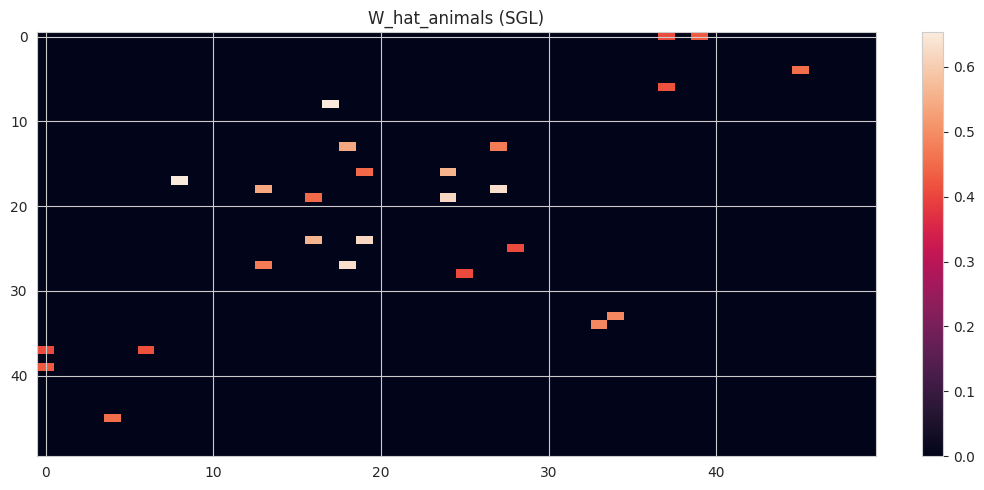

In [112]:
plt.figure(figsize=(10,5))
plt.imshow(W_hat_animals, aspect="auto")
plt.title("W_hat_animals (SGL)")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

In [113]:
W_hat_animals = adjacency_from_theta(Theta_hat_animals, thr_quantile=0.55)
G_hat_animals = nx.from_numpy_array(W_hat_animals)

[adjacency_from_theta] threshold = 0.2068


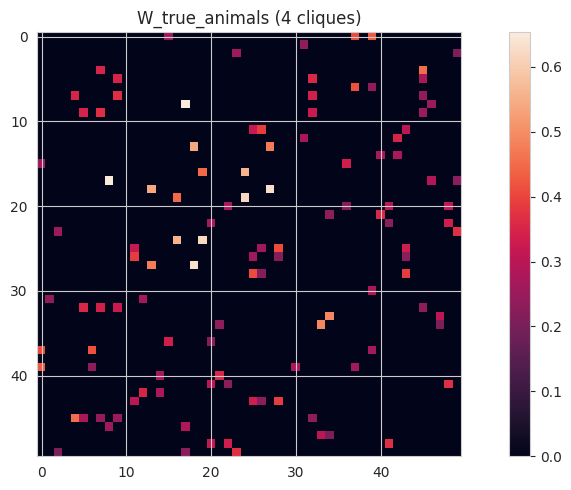

In [114]:
plt.figure(figsize=(10,5))

plt.imshow(W_hat_animals)
plt.title("W_true_animals (4 cliques)")
plt.colorbar(fraction=0.046)

plt.tight_layout()
plt.show()

In [115]:
print("Learned components (nx):", nx.number_connected_components(G_hat_animals))

Learned components (nx): 13


In [116]:
animal_names = [
    "antelope",
    "grizzly bear",
    "killer whale",
    "beaver",
    "dalmatian",
    "persian cat",
    "horse",
    "german shepherd",
    "blue whale",
    "siamese cat",
    "skunk",
    "mole",
    "tiger",
    "hippopotamus",
    "leopard",
    "moose",
    "spider monkey",
    "humpback whale",
    "elephant",
    "gorilla",
    "ox",
    "fox",
    "sheep",
    "seal",
    "chimpanzee",
    "hamster",
    "squirrel",
    "rhinoceros",
    "rabbit",
    "bat",
    "giraffe",
    "wolf",
    "chihuahua",
    "rat",
    "weasel",
    "otter",
    "buffalo",
    "zebra",
    "giant panda",
    "deer",
    "bobcat",
    "pig",
    "lion",
    "mouse",
    "polar bear",
    "collie",
    "walrus",
    "raccoon",
    "cow",
    "dolphin",
]
labels = {i: animal_names[i] for i in range(len(animal_names))}

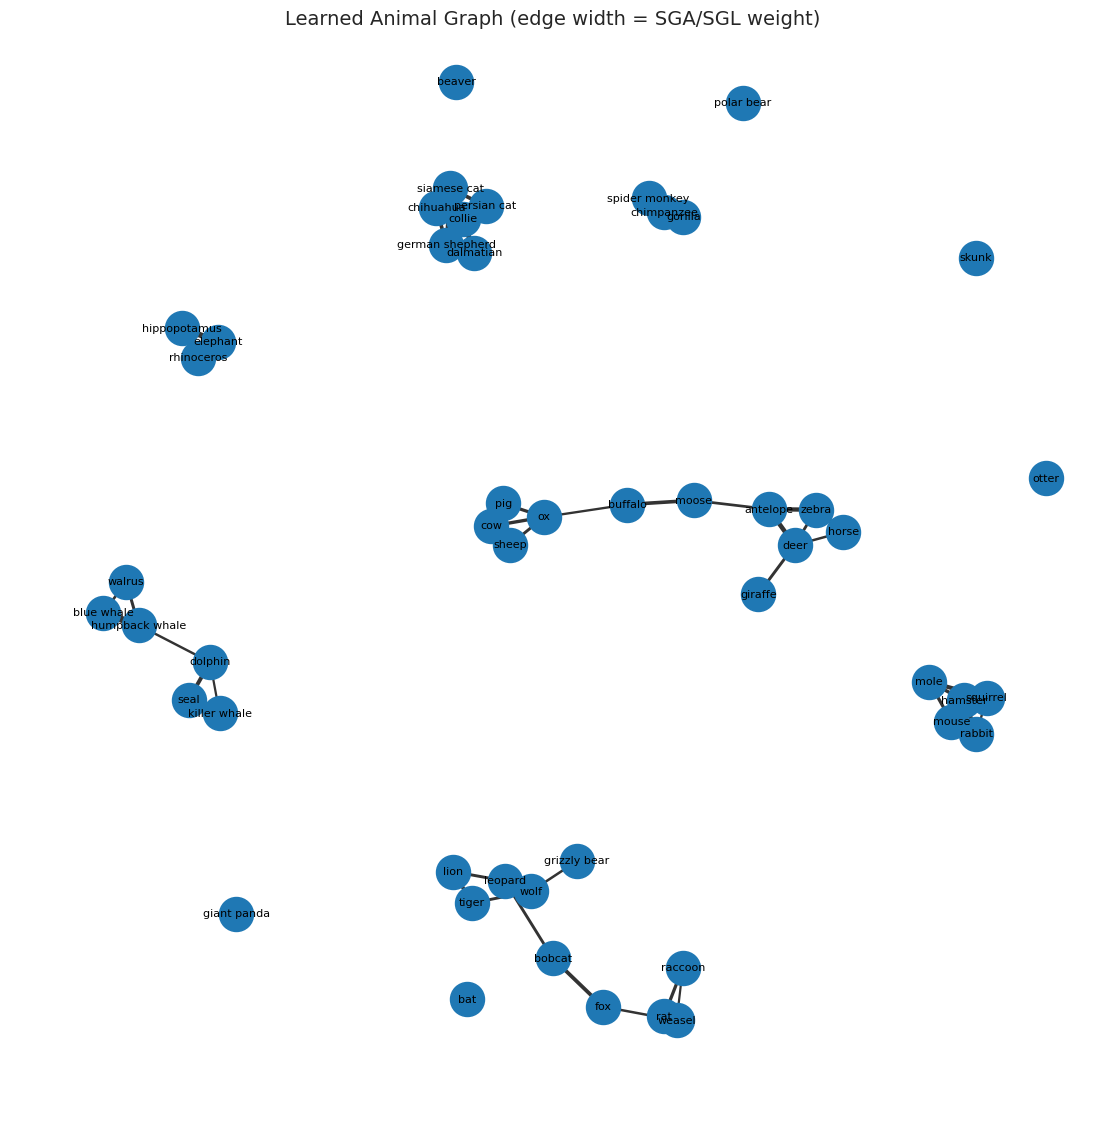

In [117]:
plt.figure(figsize=(14, 14))

pos = nx.spring_layout(G_hat_animals, seed=0)

edges = list(G_hat_animals.edges())
weights = [G_hat_animals[u][v]["weight"] for u, v in edges]

weights = np.array(weights)
if len(weights) > 0:
    widths = 5.0 * weights / weights.max()
else:
    widths = 1.0

# Draw nodes
nx.draw_networkx_nodes(
    G_hat_animals,
    pos,
    node_size=600,
)

# Draw edges with widths = learned weights
nx.draw_networkx_edges(
    G_hat_animals,
    pos,
    edgelist=edges,
    width=widths,
    alpha=0.8,
)

# Draw labels
nx.draw_networkx_labels(
    G_hat_animals,
    pos,
    labels=labels,
    font_size=8,
)

plt.title("Learned Animal Graph (edge width = SGA/SGL weight)", fontsize=14)
plt.axis("off")
plt.show()

### Testing SGL on the moons and circles datasets.

In [118]:
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

X_moons, labels_true_moons = make_moons(
    n_samples=100,
    noise=0.05,
    random_state=0
)


X_circles, labels_true_circles = make_circles(
    n_samples=200,
    factor=0.05,
    noise=0.05,
    random_state=0
)


def gaussian_similarity(X, sigma=None):

    D = cdist(X, X, metric="euclidean")
    
    if sigma is None:
        sigma = np.median(D[D > 0]) * 0.2

    W = np.exp(-(D * D) / (2 * (sigma*sigma)))
    np.fill_diagonal(W, 0.0)
    
    return W

def knn_sparsify(W, k):

    p = W.shape[0]
    Wk = np.zeros_like(W)
    
    for i in range(p):
        idx = np.argsort(W[i])[-k:]
        Wk[i, idx] = W[i, idx]
    
    return np.maximum(Wk, Wk.T)

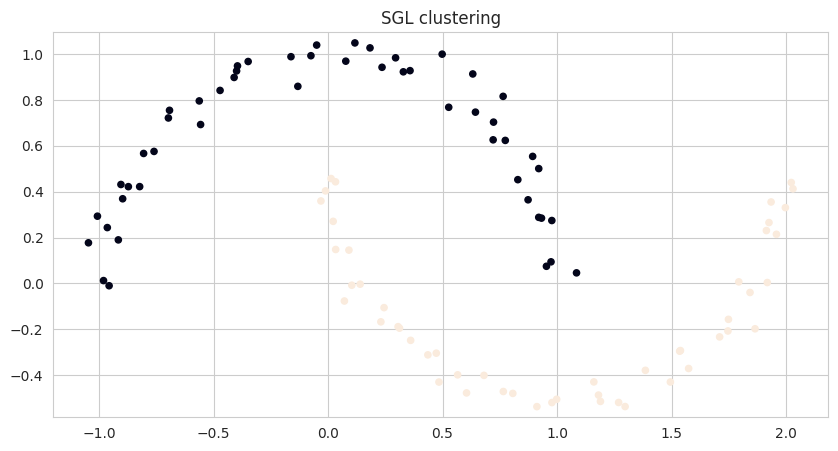

In [119]:
plt.figure(figsize=(10,5))
plt.scatter(X_moons[:,0], X_moons[:,1], c=labels_true_moons, s=20)
plt.title("SGL clustering")
plt.axis("equal")
plt.show()

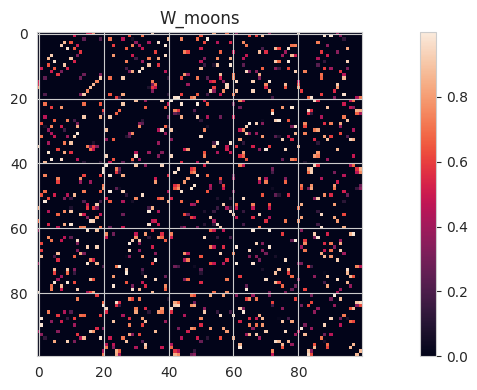

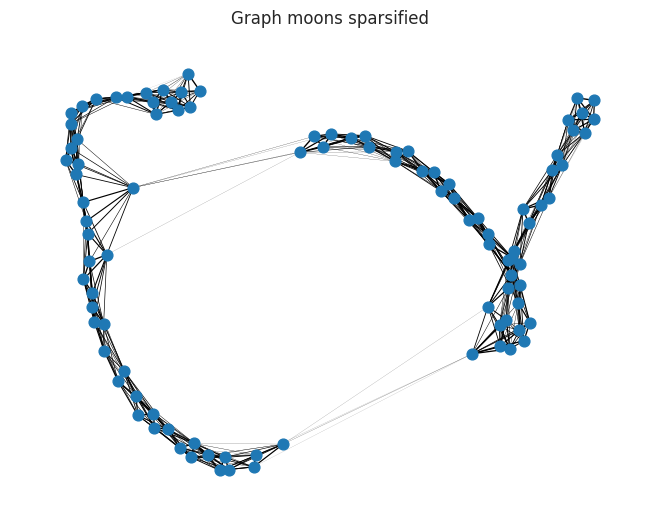

In [120]:
W_moons = gaussian_similarity(X_moons)
Theta_moons = laplacian_from_W(W_moons)
W_moons = knn_sparsify(W_moons, k=10)
G_moons = nx.from_numpy_array(W_moons)

plt.figure(figsize=(12,4))


plt.imshow(W_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_moons.edges())
p = W_moons.shape[0]
weights = np.array([G_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_moons, pos_moons, node_size=60, width=weights, edgelist=edges)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

In [121]:
p = W_moons.shape[0]

L_init = laplacian_from_W(W_moons)
S_moons = np.linalg.pinv(W_moons) + 1/3 * np.eye(p)

Theta_hat_moons, w_hat_moons, U_hat_moons, lam_hat_mooons, _ = sgl_paper_style(
    S=S_moons,
    k=2,
    alpha=0.1,     
    beta=150.0,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    reltol=1e-5,
    maxiter=1000,
)

[it=000] relchg(w)=9.983e-03, eig[k]=4.931e-02
[it=010] relchg(w)=2.623e-03, eig[k]=1.777e-01
[it=020] relchg(w)=2.224e-03, eig[k]=2.664e-01
[it=030] relchg(w)=2.146e-03, eig[k]=3.441e-01
[it=040] relchg(w)=2.126e-03, eig[k]=4.175e-01
[it=050] relchg(w)=2.110e-03, eig[k]=4.792e-01
[it=060] relchg(w)=2.078e-03, eig[k]=4.763e-01
[it=070] relchg(w)=2.021e-03, eig[k]=4.488e-01
[it=080] relchg(w)=1.972e-03, eig[k]=4.144e-01
[it=090] relchg(w)=1.982e-03, eig[k]=3.820e-01
[it=100] relchg(w)=2.052e-03, eig[k]=3.640e-01
[it=110] relchg(w)=2.233e-03, eig[k]=3.578e-01
[it=120] relchg(w)=2.281e-03, eig[k]=4.010e-01
[it=130] relchg(w)=2.116e-03, eig[k]=4.866e-01
[it=140] relchg(w)=1.945e-03, eig[k]=5.751e-01
[it=150] relchg(w)=1.759e-03, eig[k]=6.578e-01
[it=160] relchg(w)=1.586e-03, eig[k]=7.334e-01
[it=170] relchg(w)=1.437e-03, eig[k]=8.022e-01
[it=180] relchg(w)=1.317e-03, eig[k]=8.652e-01
[it=190] relchg(w)=1.222e-03, eig[k]=9.234e-01
[it=200] relchg(w)=1.147e-03, eig[k]=9.779e-01
[it=210] relc

In [122]:
W_hat_moons = adjacency_from_theta(Theta_hat_moons, thr_quantile=0.975)
G_hat_moons = nx.from_numpy_array(W_hat_moons)

[adjacency_from_theta] threshold = 0.1878


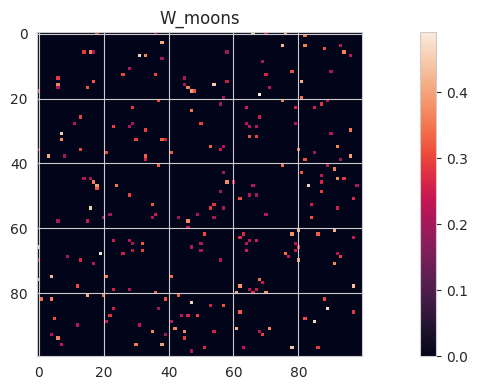

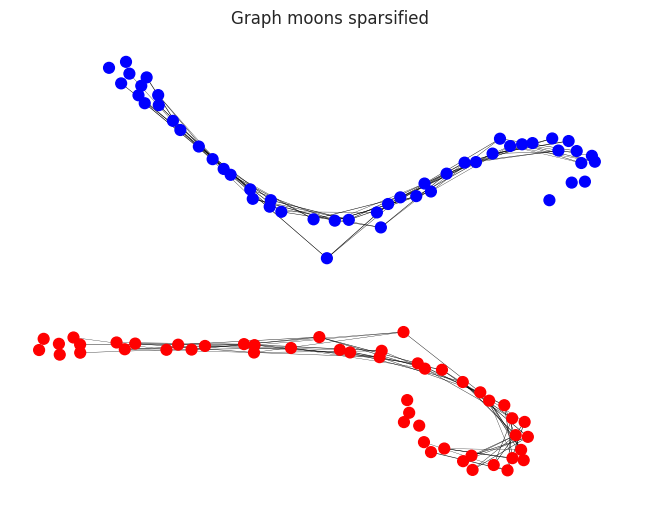

In [123]:
color_map = list()
for label in labels_true_moons:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_moons)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_moons = nx.spring_layout(G_moons)
edges = list(G_hat_moons.edges())
p = W_hat_moons.shape[0]
weights = np.array([G_hat_moons[u][v]["weight"] for u, v in edges])

nx.draw(G_hat_moons, pos_moons, node_size=60, width=weights, edgelist=edges, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

<Figure size 1200x400 with 0 Axes>

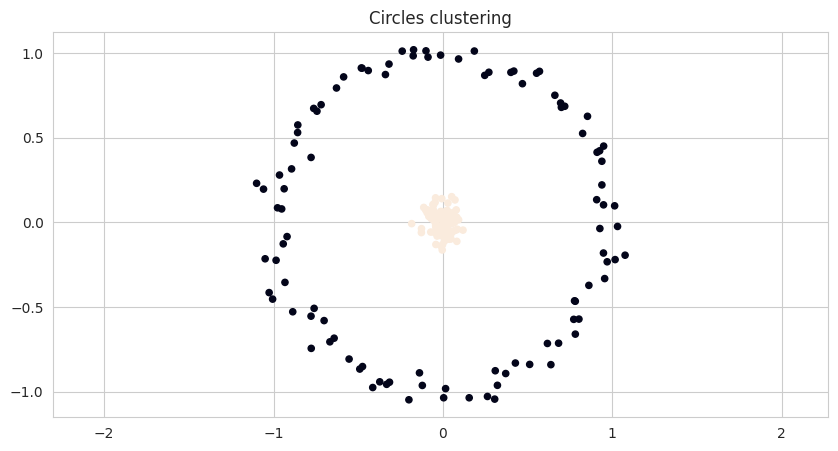

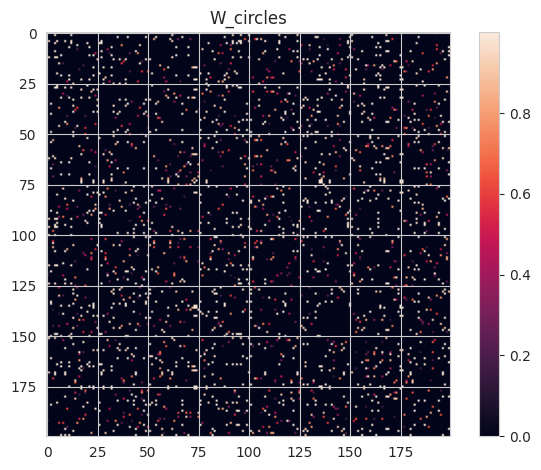

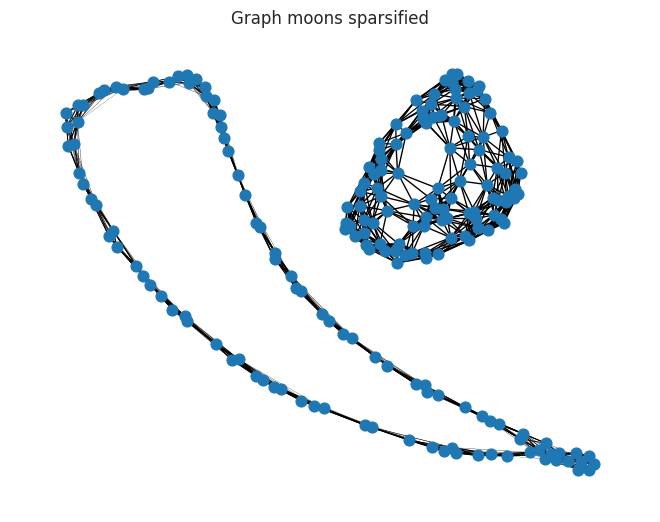

In [124]:
W_circles = gaussian_similarity(X_circles)
W_circles = knn_sparsify(W_circles, k=10)
G_circles = nx.from_numpy_array(W_circles)

plt.figure(figsize=(12,4))


plt.figure(figsize=(10,5))
plt.scatter(X_circles[:,0], X_circles[:,1], c=labels_true_circles, s=20)
plt.title("Circles clustering")
plt.axis("equal")
plt.grid(True)
plt.show()

plt.imshow(W_circles)
plt.title("W_circles")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_circles.edges())
p = W_circles.shape[0]
weights_circles = np.array([G_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

In [ ]:
p = W_circles.shape[0]
S_circles = np.linalg.pinv(W_circles) + (1/3) * np.eye(p)

Theta_hat_circles, w_hat_circles, U_hat_circles, lam_hat_circles, _ = sgl_paper_style(
    S=S_circles,
    k=2,
    alpha=0.1,     
    beta=1e2,
    eps=1e-3,
    c1=1e-5,
    c2=1e5,
    reltol=1e-5,
    maxiter=500,
)

[it=000] relchg(w)=2.290e-04, eig[k]=4.431e-02


In [ ]:
W_hat_circles = adjacency_from_theta(Theta_hat_circles)
G_hat_circles = nx.from_numpy_array(W_hat_circles)

[adjacency_from_theta] threshold = 1.236


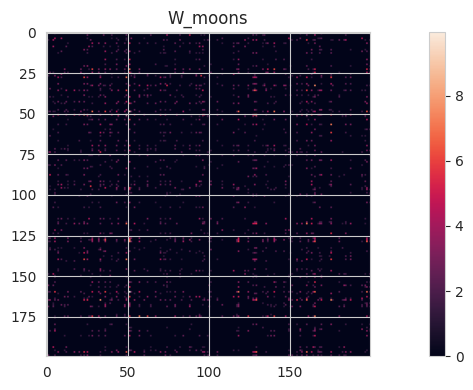

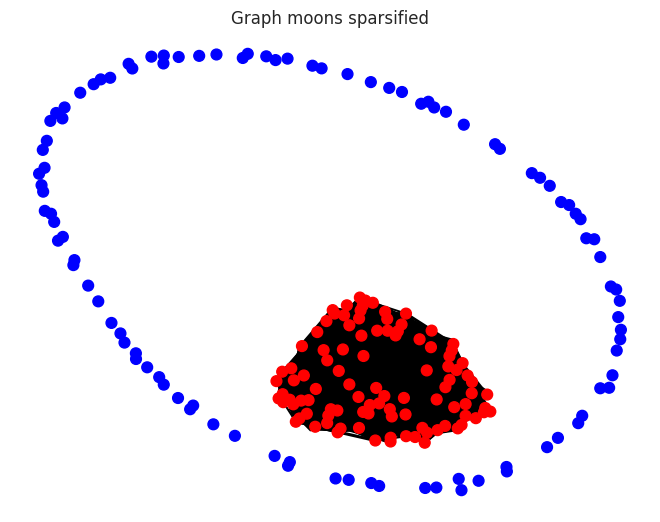

In [ ]:
color_map = list()
for label in labels_true_circles:
    if label == 1:
        color_map.append('red')
    else :
        color_map.append('blue')

color_map = np.array(color_map)

plt.figure(figsize=(12,4))

plt.imshow(W_hat_circles)
plt.title("W_moons")
plt.colorbar(fraction=0.046)
plt.tight_layout()
plt.show()

plt.figure()

pos_circles = nx.spring_layout(G_circles)
edges_circles = list(G_hat_circles.edges())
p = W_hat_circles.shape[0]
weights_circles = np.array([G_hat_circles[u][v]["weight"] for u, v in edges_circles])

nx.draw(G_hat_circles, pos_circles, node_size=60, width=weights_circles, edgelist=edges_circles, node_color=color_map)
plt.title(f"Graph moons sparsified")
plt.axis("off")
plt.show()

### Time series dataset: Temperatures in the Bretagne department, France

Here, we test the ability of SGL to recover meaningful clusters between temperature stations in the Bretagne region. This experiment is inspired by the third practical session on time series, where temperature data are analyzed from a spatio-temporal perspective.


In [ ]:
def fig_ax(figsize=(8,5)):
    fig, ax = plt.subplots(figsize=figsize)
    return fig, ax


def haversine_km(lon1, lat1, lon2, lat2):
    R = 6371.0
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def get_geodesic_distance(u, v):
    """
    u, v are (lon, lat) in degrees.
    Returns distance in km using Haversine.
    """
    lon1, lat1 = u
    lon2, lat2 = v

    R = 6371.0  # km
    phi1 = np.radians(lat1)
    phi2 =  np.radians(lat2)
    dphi =  np.radians(lat2 - lat1)
    dlambda =  np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.asin(np.sqrt(a))
    return R * c

Loading the temperature dataset as seen in the third practical session.

In [ ]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

print("data_df:", data_df.shape, "columns:", list(data_df.columns))
print("stations_df:", stations_df.shape, "columns:", list(stations_df.columns))

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [ ]:
# If you already have this list, keep it:
# STATION_LIST = [...]

if "STATION_LIST" in globals() and len(STATION_LIST) > 0:
    keep_cond = stations_df.Nom.isin(STATION_LIST)
    stations_df = stations_df[keep_cond].copy()

    keep_cond = data_df.station_name.isin(STATION_LIST)
    data_df = data_df[keep_cond].reset_index(drop=True).copy()
else:
    print("No STATION_LIST found; keeping all stations in the dataset.")

No STATION_LIST found; keeping all stations in the dataset.


In [ ]:
# Celsius 
data_df["temp"] = data_df["t"] - 273.15

# rows=time, columns=station
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name").sort_index()
print("temperature_df shape:", temperature_df.shape)

# Fill missing values 
temperature_df = temperature_df.ffill().bfill()

# Drop Nans
temperature_df = temperature_df.dropna(axis=1)
print("After fill/drop:", temperature_df.shape)

temperature_df shape: (744, 55)
After fill/drop: (744, 51)


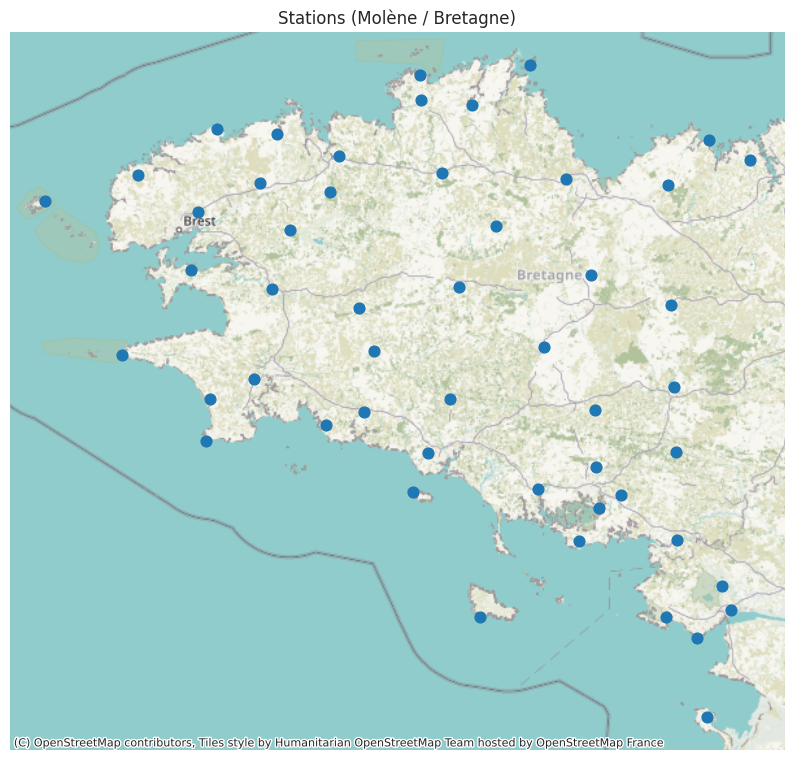

In [ ]:
CRS = "EPSG:4326"

stations_sub = stations_df.copy()
stations_gdf = gpd.GeoDataFrame(
    stations_sub,
    geometry=gpd.points_from_xy(stations_sub.Longitude, stations_sub.Latitude),
    crs=CRS
)

# Keep only stations present in temperature_df columns
stations_gdf = stations_gdf[stations_gdf["Nom"].isin(temperature_df.columns)].copy()
stations_gdf = stations_gdf.set_index("Nom").loc[list(temperature_df.columns)].reset_index()

# Plot on basemap
stations_web = stations_gdf.to_crs(epsg=3857)

fig, ax = fig_ax(figsize=(10,10))
stations_web.plot(ax=ax, markersize=60)
cx.add_basemap(ax, crs=stations_web.crs.to_string(), zoom=8)
ax.set_axis_off()
ax.set_title("Stations (Molène / Bretagne)")
plt.show()

We use the geodesic distance between stations. We also plot the temperatures of the closes stations in the graph.

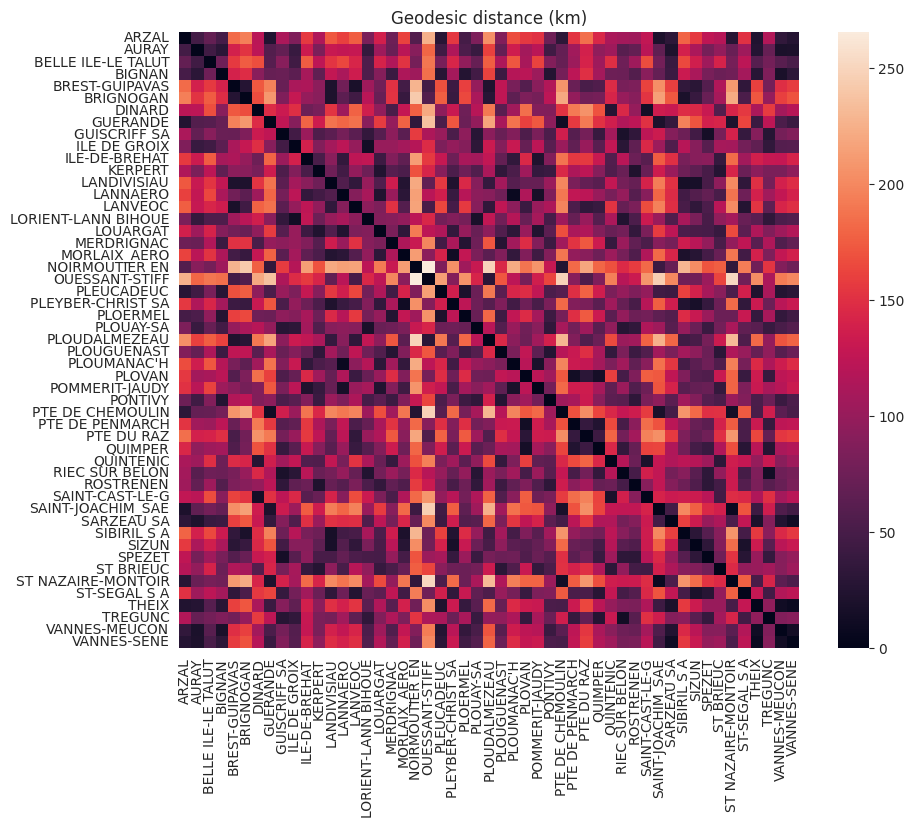

Closest stations: LANNAERO and PLOUMANAC'H
Distance: 7.846 km


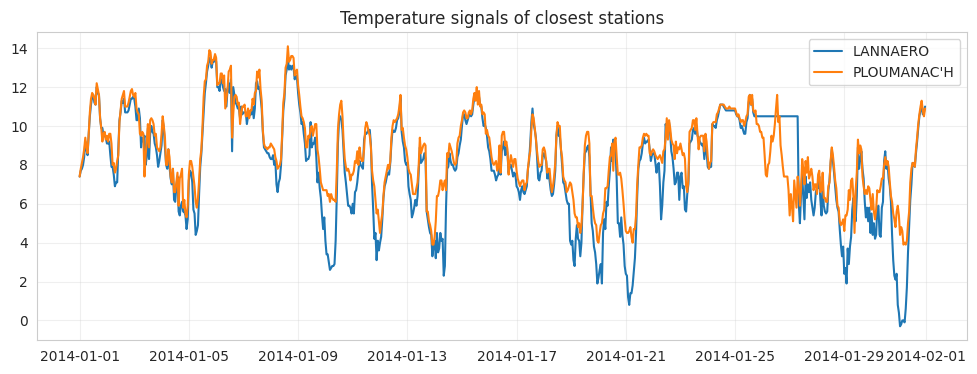

In [ ]:
stations_np = stations_gdf[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax(figsize=(10,8))
sns.heatmap(
    dist_mat_square,
    xticklabels=stations_gdf["Nom"].values,
    yticklabels=stations_gdf["Nom"].values,
    ax=ax
)
ax.set_title("Geodesic distance (km)")
plt.show()

dist_tmp = dist_mat_square.copy()
np.fill_diagonal(dist_tmp, np.inf)
min_idx = np.argmin(dist_tmp)
i, j = np.unravel_index(min_idx, dist_tmp.shape)

station1 = stations_gdf.iloc[i]["Nom"]
station2 = stations_gdf.iloc[j]["Nom"]
min_distance = dist_tmp[i, j]

print(f"Closest stations: {station1} and {station2}")
print(f"Distance: {min_distance:.3f} km")

fig, ax = fig_ax(figsize=(12,4))
ax.grid(True, alpha=0.3)
ax.plot(temperature_df[station1], label=station1)
ax.plot(temperature_df[station2], label=station2)
ax.set_title("Temperature signals of closest stations")
ax.legend()
plt.show()

The similarity matrix is the covariance matrix of the temperatures of the stations.

In [ ]:
X = temperature_df.to_numpy()             
Xc = X - X.mean(axis=0, keepdims=True)
std = Xc.std(axis=0, keepdims=True)
Xz = Xc / std

S = (Xz.T @ Xz) / Xz.shape[0]

p = S.shape[0]
S_in = S + (1/3) * np.eye(p)   

k = 4
Theta_hat, w_hat, U_hat, lam_hat, hist = sgl_paper_style(
    S=S_in,
    k=k,
    alpha=0.01,     
    beta=1e3,     
    eps=1e-2,
    c1=1e-7,
    c2=1e7,
    maxiter=1000,
    reltol=1e-5,
    verbose=True
)
print("done. iterations:", len(hist["relchg_w"]))

[it=000] relchg(w)=3.877e-02, eig[k]=1.687e+00
[it=010] relchg(w)=7.771e-03, eig[k]=1.275e+00
[it=020] relchg(w)=5.221e-03, eig[k]=1.029e+00
[it=030] relchg(w)=8.724e-03, eig[k]=7.343e-01
[it=040] relchg(w)=2.539e-03, eig[k]=6.934e-01
[it=050] relchg(w)=1.868e-03, eig[k]=6.749e-01
[it=060] relchg(w)=1.576e-03, eig[k]=6.604e-01
[it=070] relchg(w)=1.385e-03, eig[k]=6.489e-01
[it=080] relchg(w)=1.260e-03, eig[k]=6.390e-01
[it=090] relchg(w)=1.154e-03, eig[k]=6.299e-01
[it=100] relchg(w)=1.035e-03, eig[k]=6.220e-01
[it=110] relchg(w)=9.861e-04, eig[k]=6.150e-01
[it=120] relchg(w)=9.215e-04, eig[k]=6.085e-01
[it=130] relchg(w)=8.652e-04, eig[k]=6.026e-01
[it=140] relchg(w)=8.244e-04, eig[k]=5.973e-01
[it=150] relchg(w)=7.916e-04, eig[k]=5.927e-01
[it=160] relchg(w)=7.560e-04, eig[k]=5.884e-01
[it=170] relchg(w)=7.239e-04, eig[k]=5.844e-01
[it=180] relchg(w)=6.972e-04, eig[k]=5.805e-01
[it=190] relchg(w)=6.333e-04, eig[k]=5.768e-01
[it=200] relchg(w)=6.138e-04, eig[k]=5.732e-01
[it=210] relc

In [ ]:
W_hat = adjacency_from_theta(Theta_hat, thr_quantile=0.95)

[adjacency_from_theta] threshold = 0.2211


In [ ]:
G_hat = nx.from_numpy_array(W_hat)
components = list(nx.connected_components(G_hat))
print("num connected components:", len(components))

# map node to cluster id
cluster_id = np.zeros(p, dtype=int)
for cid, comp in enumerate(components):
    for node in comp:
        cluster_id[node] = cid

num connected components: 25


Here we plot and see if SGL learned some interesting components. Note that we wil get high sparsity because of the penalization factor which you can set to $\alpha = 0$ if you wish.

Nodes: 51 Edges: 28
Any NaN in coords? False
x range: -562942.6649415846 -231080.67253187345
y range: 5942835.878889969 6250321.900191935


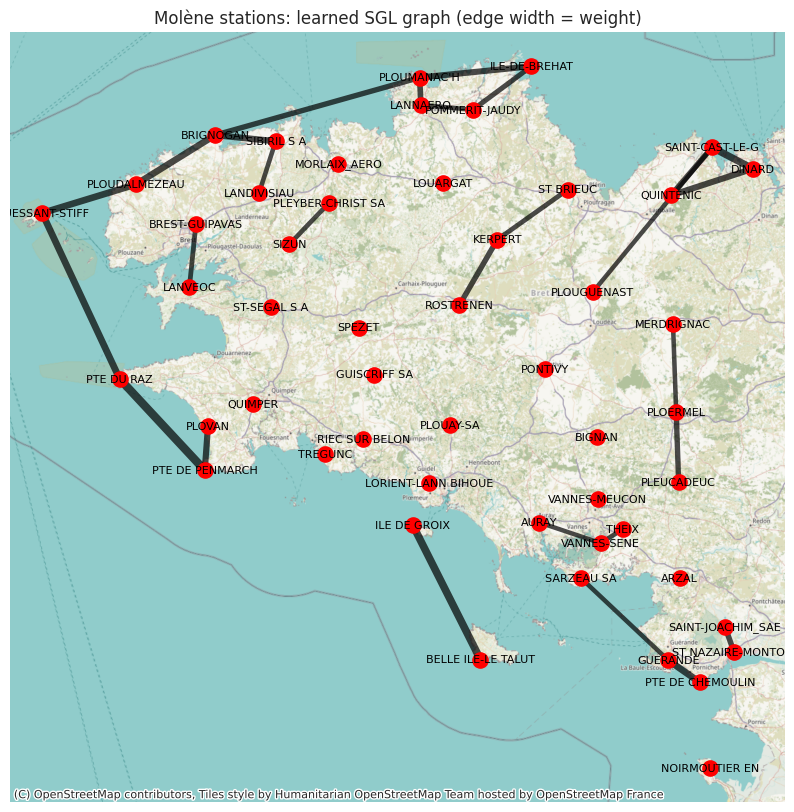

In [ ]:
# Build graph from W_hat 
G_hat = nx.from_numpy_array(W_hat)

# If empty (no edges), lower the threshold automatically
if G_hat.number_of_edges() == 0:
    W_hat, thr = adjacency_from_theta(Theta_hat, thr_quantile=0.60)
    print("Graph was empty -> lowering thr_quantile to 0.60. New thr:", thr)
    G_hat = nx.from_numpy_array(W_hat)

print("Nodes:", G_hat.number_of_nodes(), "Edges:", G_hat.number_of_edges())

# ---- Geo positions in WebMercator ----
stations_plot = stations_gdf.copy()
stations_plot = gpd.GeoDataFrame(
    stations_plot,
    geometry=gpd.points_from_xy(stations_plot.Longitude, stations_plot.Latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)


xy = np.array([(geom.x, geom.y) for geom in stations_plot.geometry])
print("Any NaN in coords?", np.isnan(xy).any())
print("x range:", xy[:,0].min(), xy[:,0].max())
print("y range:", xy[:,1].min(), xy[:,1].max())

pos = {i: (xy[i, 0], xy[i, 1]) for i in range(len(stations_plot))}


edges = list(G_hat.edges())
weights = np.array([G_hat[u][v]["weight"] for u, v in edges], dtype=float) if len(edges) else np.array([])
widths = 6.0 * (weights / (weights.max() + 1e-12)) if len(weights) else []

# Labels
labels = {i: stations_gdf["Nom"].iloc[i] for i in range(len(stations_plot))}



# ---- Plot  ----
fig, ax = plt.subplots(figsize=(10, 10))


pad = 15000  # meters
xmin, ymin, xmax, ymax = stations_plot.total_bounds
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

cx.add_basemap(ax, crs=stations_plot.crs.to_string(), zoom=9)

# Draw edges and nodes
nx.draw_networkx_edges(G_hat, pos, ax=ax, edgelist=edges, width=widths, alpha=0.7)
nx.draw_networkx_nodes(G_hat, pos, ax=ax, node_size=120, node_color="red")
nx.draw_networkx_labels(G_hat, pos, ax=ax, labels=labels, font_size=8)

ax.set_axis_off()
ax.set_title("Molène stations: learned SGL graph (edge width = weight)")
plt.show()

Let us plot the edges with their corresponding geodesic distance labels.

In [ ]:
lats = stations_gdf["Latitude"].to_numpy()
lons = stations_gdf["Longitude"].to_numpy()
edges = list(G_hat.edges())
if len(edges) == 0:
    print("No edges in G_hat.")
else:
    geo_km = np.array([haversine_km(lons[u], lats[u], lons[v], lats[v]) for u, v in edges], dtype=float)
    print("Geodesic distance stats (km): min/mean/max =", geo_km.min(), geo_km.mean(), geo_km.max())

Geodesic distance stats (km): min/mean/max = 7.8461705732034055 25.704892345629307 65.04611552719902


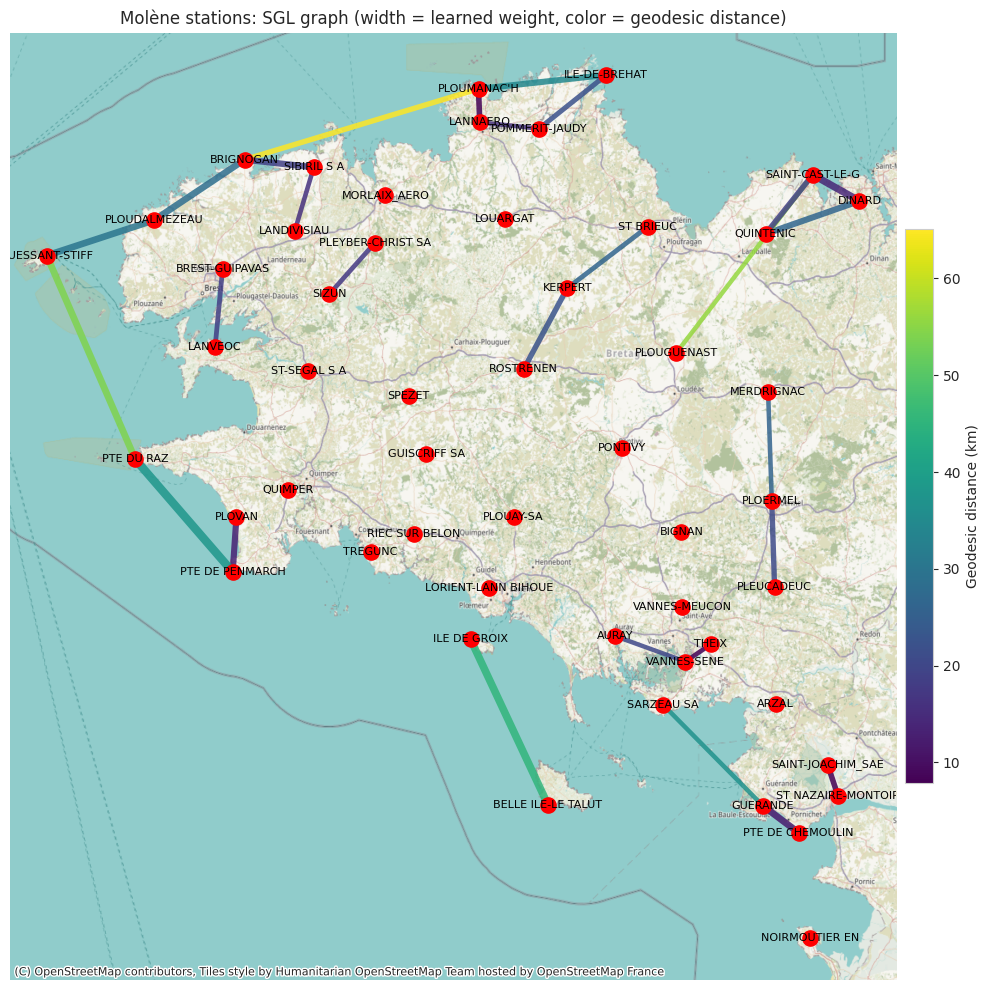

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

pad = 15000
xmin, ymin, xmax, ymax = stations_plot.total_bounds
ax.set_xlim(xmin - pad, xmax + pad)
ax.set_ylim(ymin - pad, ymax + pad)

# basemap
cx.add_basemap(ax, crs=stations_plot.crs.to_string(), zoom=9)

# edge colors by distance
norm = mlp.colors.Normalize(vmin=float(geo_km.min()), vmax=float(geo_km.max()))
cmap = plt.cm.viridis
edge_colors = cmap(norm(geo_km))

# draw
nx.draw_networkx_edges(G_hat, pos, ax=ax, edgelist=edges, width=widths, edge_color=edge_colors, alpha=0.85)
nx.draw_networkx_nodes(G_hat, pos, ax=ax, node_size=120, node_color="red")
nx.draw_networkx_labels(G_hat, pos, ax=ax, labels=labels, font_size=8)

# colorbar legend for geodesic distance
sm = mlp.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label("Geodesic distance (km)")

ax.set_axis_off()
ax.set_title("Molène stations: SGL graph (width = learned weight, color = geodesic distance)")
plt.tight_layout()
plt.show()

The SGL algorithm manages to cluster coastal cities, as they seem to have the same temperatures throughout the seasons, which seems logical.  
Could we have predicted these result using only geodesic distances ?

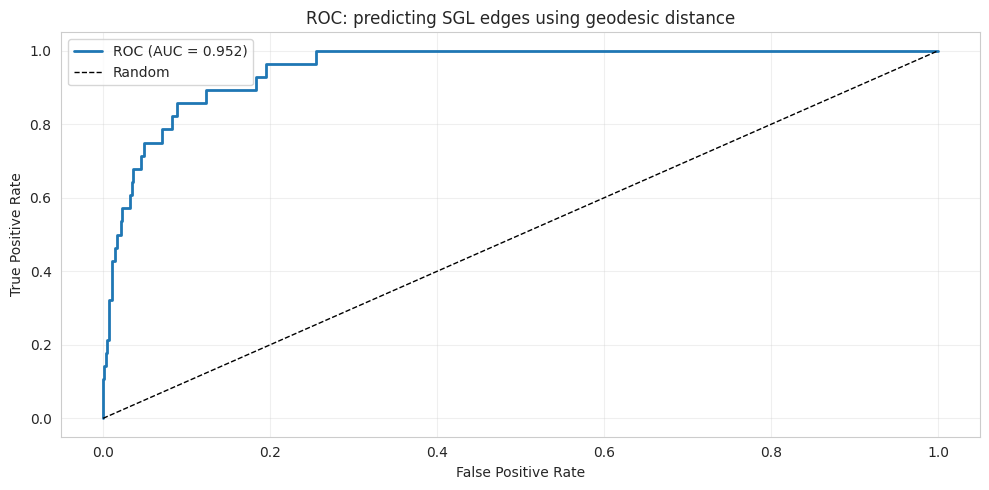

AUC = 0.9524286859892312


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_distance_roc(W_hat, dist_mat):
    """
    ROC curve:
      y = 1 if (i,j) is an edge in learned graph
      score = - geodesic distance
    """

    iu = np.triu_indices(W_hat.shape[0], k=1)
    w = W_hat[iu]
    d = dist_mat[iu]

    # binary labels: edge vs non-edge
    y_true = (w > 0).astype(int)

    # scores: closeness
    scores = -d

    if y_true.sum() < 5:
        raise ValueError("Too few edges to compute ROC.")

    auc = roc_auc_score(y_true, scores)
    fpr, tpr, _ = roc_curve(y_true, scores)

    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--", lw=1, label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC: predicting SGL edges using geodesic distance")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return auc

auc = plot_distance_roc(W_hat, dist_mat_square)
print("AUC =", auc)

The ROC curve shows the performance of geodesic distance for predicting edges recovered by SGL. The curve lies well above the random baseline, with an AUC of 0.952, indicating strong discriminative power. This suggests that geodesic distance is highly informative for identifying meaningful graph connections too.

# SGA Algorithm. Rayane's Part

### Adjacency matrix operator $\mathcal{A}$ and adjoint $\mathcal{A}^\star$

Let $w \in \mathbb{R}^m$ with $m = \frac{p(p-1)}{2}$ be the vector of edge weights.

The operator
$$
\mathcal{A} : \mathbb{R}^m \to \mathbb{S}^p
$$
maps $w$ to the symmetric adjacency matrix $W = \mathcal{A}(w)$ defined by
$$
W_{ij} =
\begin{cases}
w_{ij}, & i \neq j, \\
0, & i = j .
\end{cases}
$$

The adjoint operator
$$
\mathcal{A}^\star : \mathbb{S}^p \to \mathbb{R}^m
$$
satisfies
$$
\langle \mathcal{A}(w), X \rangle_F = \langle w, \mathcal{A}^\star(X) \rangle ,
$$
and is given componentwise by
$$
(\mathcal{A}^\star(X))_{ij} = 2X_{ij}, \quad i < j .
$$


We first start off by a class to implement the SGA algorithm with its corresponding fit and infer methods. We also use the $\ell_1$ regularization and log-barrier approach.

In [ ]:
class GraphLearningSGA_barrier:
    
    def __init__(self, alpha=0.01, gamma=100, max_iter=50, tol=1e-4, epsilon=1e-3):

        self.alpha = alpha
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.epsilon = epsilon
        self.w_ = None
        self.L_ = None
        self.A_ = None

    def _L_operator(self, w, p, iu):
        """Laplacian operator L(w)."""
        
        L = np.zeros((p, p))
        L[iu] = -w
        L = L + L.T
        np.fill_diagonal(L, -np.sum(L, axis=1))
        return L

    def _A_operator(self, w, p, iu):
        """Adjacency operator A(w)."""
        
        A = np.zeros((p, p))
        A[iu] = w
        A = A + A.T
        return A

    def _L_adjoint(self, M, p, iu):
        """Adjoint of the Laplacian operator L*(M)."""
        
        diag = np.diag(M)
        return diag[iu[0]] + diag[iu[1]] - 2 * M[iu]

    def _A_adjoint(self, M, iu):
        """Adjoint of the adjacency operator A*(M)."""
        return 2 * M[iu]

    def fit(self, S):
        p = S.shape[0]
        n_edges = p * (p - 1) // 2
        iu = np.triu_indices(p, k=1)
        
        # Initialization based on the inverse covariance when available
        try:
            S_inv = np.linalg.pinv(S)
            w = np.abs(S_inv[iu])
        except:
            w = np.random.uniform(0.1, 1.0, n_edges)
        
        # Rank-one centering matrix
        J = (1.0 / p) * np.ones((p, p))

        # Spectral initialization
        A_init = self._A_operator(w, p, iu)
        psi, V = eigh(A_init)
        
        for t in range(self.max_iter):
            w_old = w.copy()
            
            # Current Laplacian and adjacency matrices
            Lw = self._L_operator(w, p, iu)
            Aw = self._A_operator(w, p, iu)
            
            # Spectral update
            evals_temp, V = eigh(Aw)
            idx = np.argsort(evals_temp)[::-1]
            psi = evals_temp[idx]
            V = V[:, idx]
            
            # Bipartite spectral projection
            psi_sym = np.zeros_like(psi)
            half = p // 2
            for i in range(half):
                val = (psi[i] - psi[p - 1 - i]) / 2.0
                psi_sym[i] = val
                psi_sym[p - 1 - i] = -val
            if p % 2 != 0:
                psi_sym[half] = 0
            psi = np.sort(psi_sym)[::-1]

            # Inverse Laplacian term
            try:
                inv_term = np.linalg.pinv(Lw + J)
            except:
                inv_term = np.linalg.pinv(Lw + J + 1e-6 * np.eye(p))
            
            # Data fidelity gradient
            grad_S = (1.0 / self.gamma) * self._L_adjoint(S, p, iu)
            
            # Log-determinant barrier gradient
            grad_inv = (1.0 / self.gamma) * self._L_adjoint(inv_term, p, iu)
            
            # Spectral regularization gradient
            M_spectral = V @ np.diag(psi) @ V.T
            grad_spectral = self._A_adjoint(Aw, iu) - self._A_adjoint(M_spectral, iu)
            
            # Sparsity-inducing barrier
            grad_sparsity = (self.alpha / self.gamma) * (1.0 / (self.epsilon + w))
            
            # Global gradient
            grad = (grad_S - grad_inv) + grad_spectral + grad_sparsity
            
            # Step size
            L_const = 2.0 + (1.0 / self.gamma)
            
            # Projected gradient update
            w = np.maximum(0, w - (1.0 / L_const) * grad)

            # Convergence check
            diff = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-10)
            if diff < self.tol:
                print(f"Convergence at iteration {t}")
                break
        
        self.w_ = w
        self.L_ = self._L_operator(w, p, iu)
        self.A_ = self._A_operator(w, p, iu)
        return self

In [ ]:
class GraphLearningSGA:
    
    def __init__(self, alpha=0.01, gamma=100, max_iter=50, tol=1e-4, epsilon=1e-3):
        self.alpha = alpha
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.epsilon = epsilon
        self.w_ = None
        self.L_ = None
        self.A_ = None

    def _L_operator(self, w, p, iu):
        """Laplacian operator L(w)."""
        L = np.zeros((p, p))
        L[iu] = -w
        L = L + L.T
        np.fill_diagonal(L, -np.sum(L, axis=1))
        return L

    def _A_operator(self, w, p, iu):
        """Adjacency operator A(w)."""
        A = np.zeros((p, p))
        A[iu] = w
        A = A + A.T
        return A

    def _L_adjoint(self, M, p, iu):
        """Adjoint of the Laplacian operator L*(M)."""
        diag = np.diag(M)
        return diag[iu[0]] + diag[iu[1]] - 2 * M[iu]

    def _A_adjoint(self, M, iu):
        """Adjoint of the adjacency operator A*(M)."""
        return 2 * M[iu]

    def fit(self, S):
        p = S.shape[0]
        n_edges = p * (p - 1) // 2
        iu = np.triu_indices(p, k=1)
        
        # Initialization based on the inverse covariance when available
        try:
            S_inv = np.linalg.pinv(S)
            w = np.abs(S_inv[iu])
        except:
            w = np.random.uniform(0.1, 1.0, n_edges)
        
        # Centering matrix and modified covariance term
        J = (1.0 / p) * np.ones((p, p))
        K = S + self.alpha * (2 * np.eye(p) - np.ones((p, p)))

        # Spectral initialization
        A_init = self._A_operator(w, p, iu)
        psi, V = eigh(A_init)
        
        for t in range(self.max_iter):
            w_old = w.copy()
            
            # Current Laplacian and adjacency matrices
            Lw = self._L_operator(w, p, iu)
            Aw = self._A_operator(w, p, iu)
            
            # Spectral decomposition
            evals_temp, V = eigh(Aw)
            idx = np.argsort(evals_temp)[::-1]
            psi = evals_temp[idx]
            V = V[:, idx]
            
            # Bipartite spectral projection
            psi_sym = np.zeros_like(psi)
            half = p // 2
            for i in range(half):
                val = (psi[i] - psi[p - 1 - i]) / 2.0
                psi_sym[i] = val
                psi_sym[p - 1 - i] = -val
            if p % 2 != 0:
                psi_sym[half] = 0
            psi = np.sort(psi_sym)[::-1]

            # Inverse Laplacian term
            try:
                inv_term = np.linalg.pinv(Lw + J)
            except:
                inv_term = np.linalg.pinv(Lw + J + 1e-6 * np.eye(p))

            # Gradient components
            grad_inv = (1.0 / self.gamma) * self._L_adjoint(inv_term, p, iu)
            M_spectral = V @ np.diag(psi) @ V.T
            grad_spectral = self._A_adjoint(Aw, iu)
            grad_c = self._A_adjoint(M_spectral, iu) - (1.0 / self.gamma) * self._L_adjoint(K, p, iu)
            
            # Global gradient
            grad = grad_inv + grad_spectral - grad_c
            
            # Step size
            L_const = 2 + 1 / self.gamma
            
            # Projected gradient update
            w = np.maximum(0, w - (1.0 / L_const) * grad)

            # Convergence check
            diff = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-10)
            if diff < self.tol:
                print(f"Convergence at iteration {t}")
                break
    
        self.w_ = w
        self.L_ = self._L_operator(w, p, iu)
        self.A_ = self._A_operator(w, p, iu)
        return self

In [ ]:
from scipy.linalg import pinv
n_nodes = 30
n1, n2 = 15, 15 

# Low edge probability to enforce sparsity
G_true = nx.bipartite.random_graph(n1, n2, p=0.2, seed=42)
W_true = nx.to_numpy_array(G_true)

# Theta = Laplacian + diagonal regularization for invertibility
L_true = np.diag(np.sum(W_true, axis=1)) - W_true
Theta_true = L_true + 1e-1 * np.eye(n_nodes)

# Samples are drawn from X ~ N(0, Theta^{-1})
n_samples = 1000
Cov_true = pinv(Theta_true)

# Multivariate Gaussian sampling
X = np.random.multivariate_normal(
    mean=np.zeros(n_nodes),
    cov=Cov_true,
    size=n_samples
)

# Empirical covariance matrix
S_sample = np.cov(X.T)

Running grid search over 12 combinations...
Testing: alpha=0.01, gamma=10000 ... -> FS: 0.8983
Testing: alpha=0.05, gamma=10000 ... -> FS: 0.8983
Testing: alpha=0.1, gamma=10000 ... -> FS: 0.8983
Testing: alpha=0.01, gamma=10000 ... -> FS: 0.8983
Testing: alpha=0.05, gamma=10000 ... -> FS: 0.8983
Testing: alpha=0.1, gamma=10000 ... -> FS: 0.8983
Testing: alpha=0.01, gamma=100000 ...Convergence at iteration 158
 -> FS: 0.8833
Testing: alpha=0.05, gamma=100000 ...Convergence at iteration 158
 -> FS: 0.8833
Testing: alpha=0.1, gamma=100000 ...Convergence at iteration 161
 -> FS: 0.8833
Testing: alpha=0.01, gamma=50000 ...Convergence at iteration 151
 -> FS: 0.8833
Testing: alpha=0.05, gamma=50000 ...Convergence at iteration 151
 -> FS: 0.8833
Testing: alpha=0.1, gamma=50000 ...Convergence at iteration 152
 -> FS: 0.8833

BEST CONFIGURATION FOUND
Alpha: 0.01
Gamma: 10000.0
F-score: 0.8983
Relative Error: 0.2415


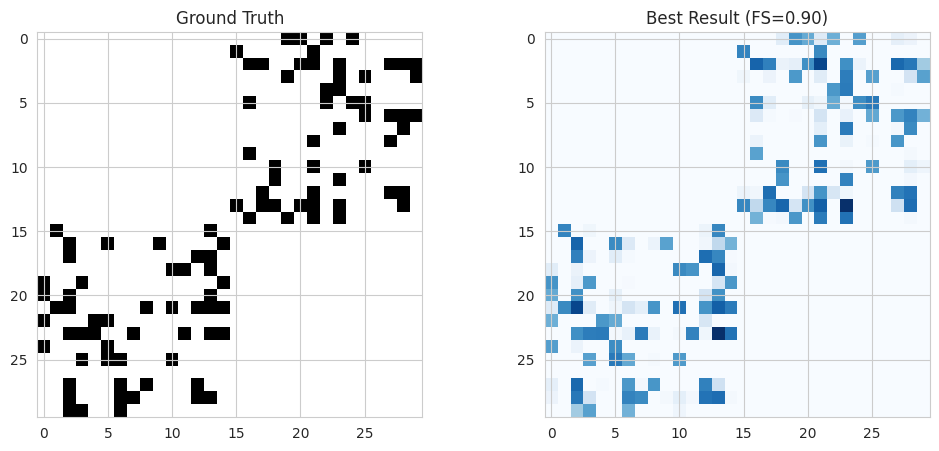

In [ ]:
# Hyperparameter search space
alphas = [0.01, 0.05, 0.1]
gammas = [10000, 10000, 100000, 50000]

results = []

print(f"Running grid search over {len(alphas) * len(gammas)} combinations...")

for g in gammas:
    for a in alphas:
        print(f"Testing: alpha={a}, gamma={g} ...", end="")
        
        # Model re-initialization for each configuration
        model = GraphLearningSGA(alpha=a, gamma=g, max_iter=300, tol=1e-4)
        model.fit(S_sample)
        
        # Post-processing of the learned adjacency
        W_clean = model.A_.copy()
        W_clean[W_clean < 1e-3] = 0
        
        # Performance evaluation
        met = evaluate_graph_performance(W_true, W_clean, threshold=0.2)
        
        print(f" -> FS: {met['FS']:.4f}")
        
        results.append({
            'alpha': a,
            'gamma': g,
            'FS': met['FS'],
            'RE': met['RE']
        })

# Selection of the best configuration
df_res = pd.DataFrame(results)
best_run = df_res.loc[df_res['FS'].idxmax()]

print("\n" + "=" * 40)
print("BEST CONFIGURATION FOUND")
print("=" * 40)
print(f"Alpha: {best_run['alpha']}")
print(f"Gamma: {best_run['gamma']}")
print(f"F-score: {best_run['FS']:.4f}")
print(f"Relative Error: {best_run['RE']:.4f}")

# Visualization 
best_model = GraphLearningSGA(
    alpha=best_run['alpha'],
    gamma=best_run['gamma'],
    max_iter=1000,
    tol=1e-5
)
best_model.fit(S_sample)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(W_true, cmap="Greys")

plt.subplot(1, 2, 2)
plt.title(f"Best Result (FS={best_run['FS']:.2f})")
plt.imshow(best_model.A_, cmap="Blues")

plt.show()

Monte Carlo (15 trials per noise level)...
Noise level kappa = 0.00
Convergence at iteration 56
Convergence at iteration 68
Convergence at iteration 52
Convergence at iteration 58
Convergence at iteration 55
Convergence at iteration 58
Convergence at iteration 46
Convergence at iteration 52
Convergence at iteration 41
Convergence at iteration 59
Convergence at iteration 54
Convergence at iteration 62
Convergence at iteration 48
Convergence at iteration 51
Convergence at iteration 53
Convergence at iteration 57
Convergence at iteration 48
Convergence at iteration 59
Convergence at iteration 58
Convergence at iteration 61
Convergence at iteration 42
Convergence at iteration 54
Convergence at iteration 46
Convergence at iteration 55
Convergence at iteration 45
Convergence at iteration 54
Convergence at iteration 48
Convergence at iteration 53
Convergence at iteration 49
Convergence at iteration 61
Noise level kappa = 0.20
Convergence at iteration 93
Convergence at iteration 107
Convergenc

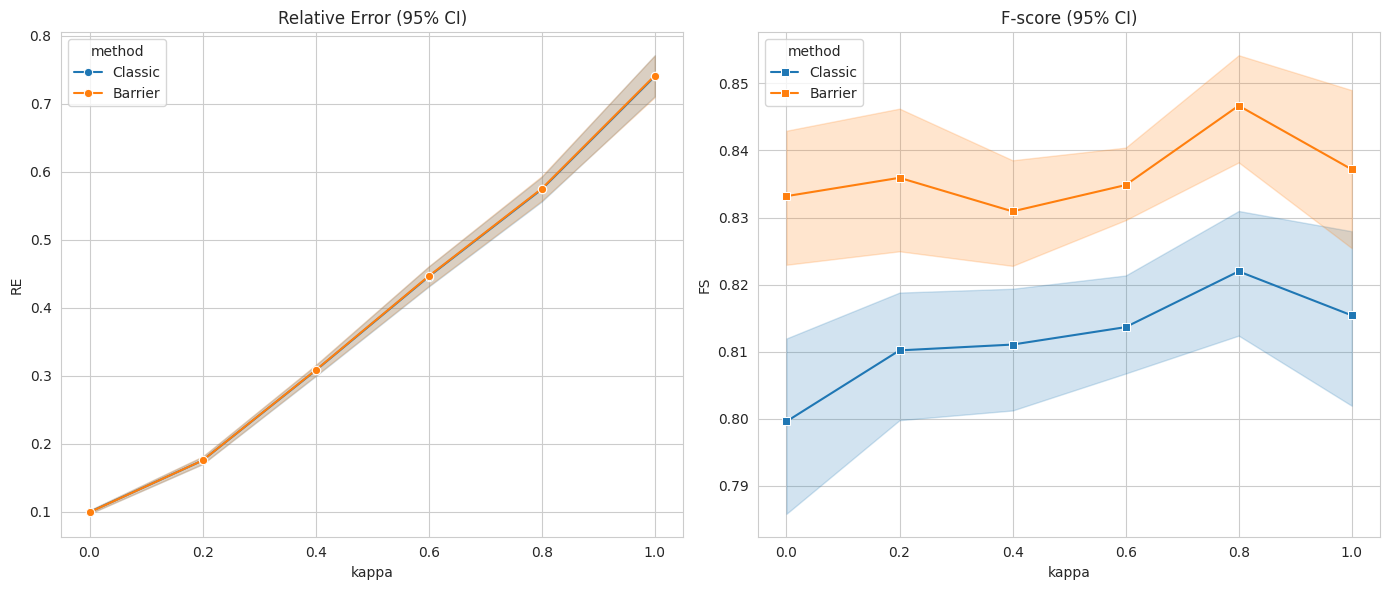

In [ ]:
def run_monte_carlo_sensitivity(n_trials=20):
    p = 32
    n1, n2 = 20, 12
    n_samples = p * 500
    noise_intensities = np.linspace(0.0, 1.0, 6)
    
    res = []

    print(f"Monte Carlo ({n_trials} trials per noise level)...")

    for kappa in noise_intensities:
        print(f"Noise level kappa = {kappa:.2f}")
        for run in range(n_trials):
            G_bi = nx.bipartite.random_graph(n1, n2, p=0.7)
            W_bi = nx.to_numpy_array(G_bi) * np.random.uniform(0.1, 1.0, (p, p))
            W_bi = (W_bi + W_bi.T) / 2
            
            W_noise = nx.to_numpy_array(nx.erdos_renyi_graph(p, 0.35)) * np.random.uniform(0, kappa, (p, p))
            W_noise = (W_noise + W_noise.T) / 2
            
            W_noisy = W_bi + W_noise
            L_noisy = np.diag(np.sum(W_noisy, axis=1)) - W_noisy
            
            Cov = np.linalg.pinv(L_noisy + 1e-6 * np.eye(p))
            X = np.random.multivariate_normal(np.zeros(p), Cov, n_samples)
            S = np.cov(X.T)

            m_classic = GraphLearningSGA(alpha=0.1, gamma=1e5, max_iter=500).fit(S)
            eval_c = evaluate_graph_performance(W_bi, m_classic.A_)
            
            m_barrier = GraphLearningSGA_barrier(alpha=0.1, gamma=1e5, max_iter=500).fit(S)
            eval_b = evaluate_graph_performance(W_bi, m_barrier.A_)
            
            res.append({'kappa': kappa, 'trial': run, 'method': 'Classic', 'RE': eval_c["RE"], 'FS': eval_c["FS"]})
            res.append({'kappa': kappa, 'trial': run, 'method': 'Barrier', 'RE': eval_b["RE"], 'FS': eval_b["FS"]})

    df = pd.DataFrame(res)
    
    stats = (
        df.groupby(['kappa', 'method'])[['RE', 'FS']]
        .agg(['mean', 'std', 'sem'])
        .reset_index()
    )

    print("\nStatistical summary (first rows):")
    print(stats.head())

    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")

    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='kappa', y='RE', hue='method', marker='o', errorbar=('ci', 95))
    plt.title('Relative Error (95% CI)')
    plt.ylabel('RE')

    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x='kappa', y='FS', hue='method', marker='s', errorbar=('ci', 95))
    plt.title('F-score (95% CI)')
    plt.ylabel('FS')

    plt.tight_layout()
    plt.savefig('monte_carlo_analysis.png')
    df.to_csv('monte_carlo_results_raw.csv', index=False)
    
    return df, stats


df_raw, df_stats = run_monte_carlo_sensitivity(n_trials=15)

The SGA-log-barrier method yields surprisignly better results than the $\ell_1$-regularization approach by the authors.

### NYC Bikes (Citi Bike) dataset

The NYC Bikes (Citi Bike) dataset contains detailed records of individual bike-sharing trips in New York City. Each row corresponds to a single ride, with information about the start and end times, stations, and user type.

In this notebook, we use the January 2023 dataset (`202301-citibike-tripdata.csv`). Such data are commonly used to study urban mobility patterns, construct graphs between stations, and analyze temporal usage dynamics.


In [ ]:
df_raw = pd.read_csv('202301-citibike-tripdata.csv')

/tmp/ipykernel_11171/847298142.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('202301-citibike-tripdata.csv')


In [ ]:
def get_bipartite_data(df, n_stations=50):
    """
    Prepares a bipartite time series dataset for top stations.
    Returns a bipartite correlation matrix, normalized flows, and top stations.
    """

    # Ensure datetime columns
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['h_start'] = df['started_at'].dt.floor('H')
    df['h_end'] = df['ended_at'].dt.floor('H')

    # Compute total departures and arrivals per station
    stats_out = df['start_station_name'].value_counts()
    stats_in = df['end_station_name'].value_counts()

    # Compare inflow vs outflow
    diff_df = pd.DataFrame({'out': stats_out, 'in': stats_in}).fillna(0)
    diff_df['net'] = diff_df['out'] - diff_df['in']

    # Most asymmetric stations (top sources and sinks)
    top_sources = diff_df.sort_values('net', ascending=False).head(n_stations).index
    top_sinks = diff_df.sort_values('net', ascending=True).head(n_stations).index
    
    top_stations = df['start_station_name'].value_counts().nlargest(n_stations).index

    # Hourly aggregated flows
    outflow = (
        df[df['start_station_name'].isin(top_sources)]
        .groupby(['h_start', 'start_station_name'])
        .size()
        .unstack(fill_value=0)
    )
    inflow = (
        df[df['end_station_name'].isin(top_sinks)]
        .groupby(['h_end', 'end_station_name'])
        .size()
        .unstack(fill_value=0)
    )

    # Align indices (hours)
    common_index = outflow.index.intersection(inflow.index)
    outflow = outflow.loc[common_index]
    inflow = inflow.loc[common_index]

    # Concatenate departures and arrivals
    combined_flow = pd.concat([outflow, inflow], axis=1)

    # --- Preprocessing / Diagnostics ---
    # 1. Log transform to stabilize variance
    combined_log = np.log1p(combined_flow)

    # 2. First-order differencing for stationarity
    combined_diff = combined_log.diff().dropna()

    # 3. Z-score normalization
    combined_flow_norm = (combined_diff - combined_diff.mean()) / combined_diff.std()

    # Correlation matrix on stationary flows
    S_full = np.corrcoef(combined_flow_norm.T)

    # Bipartite masking (departures x arrivals)
    mask = np.zeros_like(S_full)
    mask[:n_stations, n_stations:] = 1
    mask[n_stations:, :n_stations] = 1
    S_bipartite = S_full * mask

    return S_bipartite, combined_flow_norm, top_stations


S_bip, ts_combined, stations = get_bipartite_data(df_raw)

/tmp/ipykernel_11171/2712342180.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['h_start'] = df['started_at'].dt.floor('H')
/tmp/ipykernel_11171/2712342180.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['h_end'] = df['ended_at'].dt.floor('H')


Convergence at iteration 0


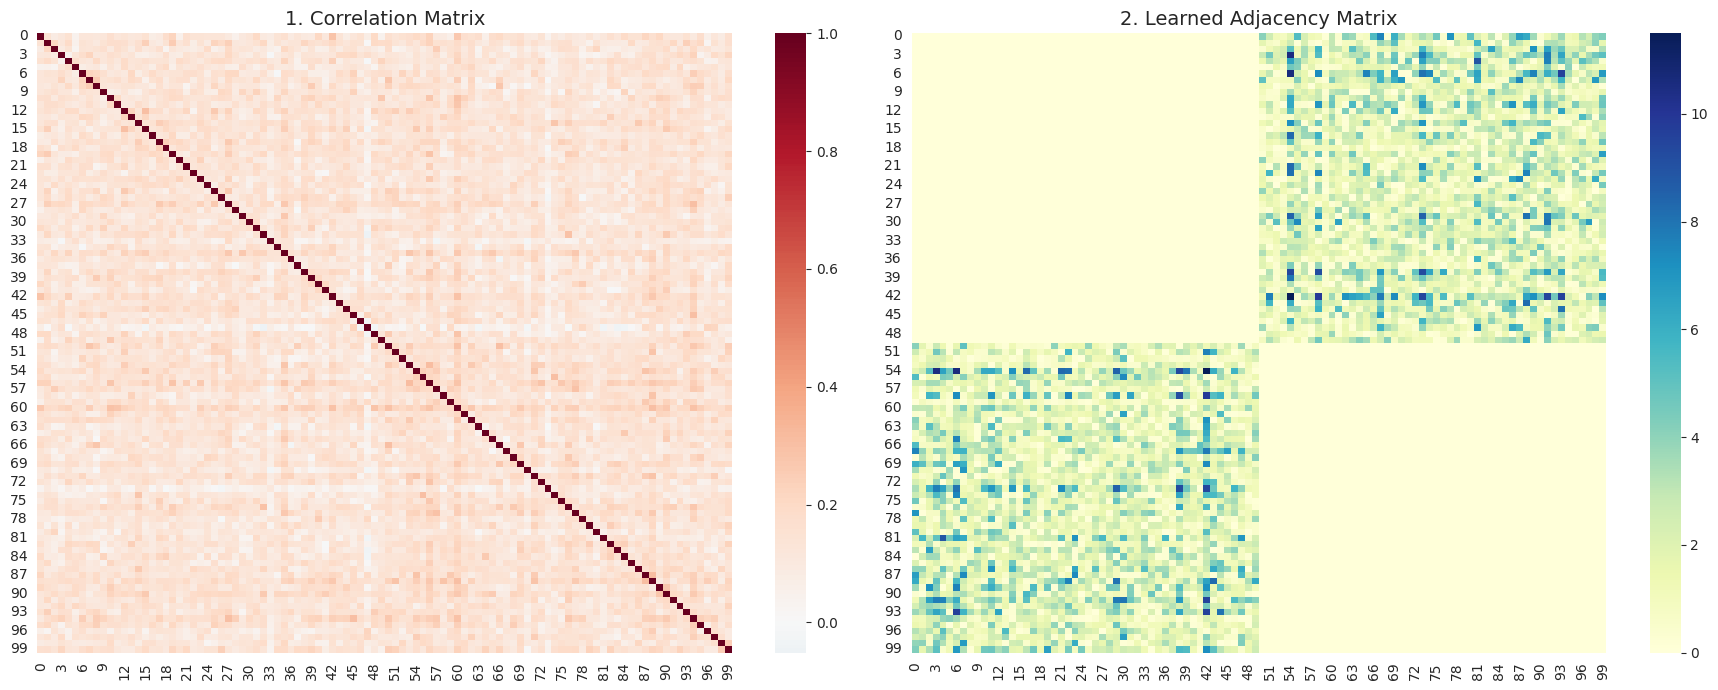

Number of edges retained: 2500 out of 4950


In [ ]:
model = GraphLearningSGA(alpha=0.05, gamma=1e5, max_iter=100)
model.fit(S_bip)

# Plot correlation matrix vs learned adjacency
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(np.corrcoef(ts_combined.T), ax=ax[0], cmap='RdBu_r', center=0, cbar=True)
ax[0].set_title("1. Correlation Matrix", fontsize=14)

sns.heatmap(model.A_, ax=ax[1], cmap='YlGnBu', cbar=True)
ax[1].set_title("2. Learned Adjacency Matrix", fontsize=14)

plt.tight_layout()
plt.show()

# count non-zero edges
n_edges = np.count_nonzero(model.w_ > 1e-4)
print(f"Number of edges retained: {n_edges} out of {len(model.w_)}")

In [ ]:
def get_regular_data(df, n_stations=50):
    """
    Prepares regular (non-bipartite) time series data for top stations.
    Returns the correlation matrix, normalized flows, and top stations.
    """
    # Ensure datetime columns
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['h_start'] = df['started_at'].dt.floor('H')
    df['h_end'] = df['ended_at'].dt.floor('H')

    # Compute total departures and arrivals per station
    stats_out = df['start_station_name'].value_counts()
    stats_in = df['end_station_name'].value_counts()

    # Compare inflow vs outflow
    diff_df = pd.DataFrame({'out': stats_out, 'in': stats_in}).fillna(0)
    diff_df['net'] = diff_df['out'] - diff_df['in']

    # Most asymmetric stations
    top_sources = diff_df.sort_values('net', ascending=False).head(n_stations).index
    top_sinks = diff_df.sort_values('net', ascending=True).head(n_stations).index
    
    top_stations = df['start_station_name'].value_counts().nlargest(n_stations).index

    # Hourly aggregated flows
    outflow = (
        df[df['start_station_name'].isin(top_sources)]
        .groupby(['h_start', 'start_station_name'])
        .size()
        .unstack(fill_value=0)
    )
    inflow = (
        df[df['end_station_name'].isin(top_sinks)]
        .groupby(['h_end', 'end_station_name'])
        .size()
        .unstack(fill_value=0)
    )

    # Align indices
    common_index = outflow.index.intersection(inflow.index)
    outflow = outflow.loc[common_index]
    inflow = inflow.loc[common_index]

    # Concatenate departures and arrivals
    combined_flow = pd.concat([outflow, inflow], axis=1)

    # --- Preprocessing ---
    combined_log = np.log1p(combined_flow)                  
    combined_diff = combined_log.diff().dropna()            
    combined_flow_norm = (combined_diff - combined_diff.mean()) / combined_diff.std()  

    # Correlation matrix on normalized flows
    S_full = np.corrcoef(combined_flow_norm.T)

    return S_full, combined_flow_norm, top_stations


S_full, ts_combined_regular, stations_regular = get_regular_data(df_raw)

/tmp/ipykernel_11171/3878501215.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['h_start'] = df['started_at'].dt.floor('H')
/tmp/ipykernel_11171/3878501215.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['h_end'] = df['ended_at'].dt.floor('H')


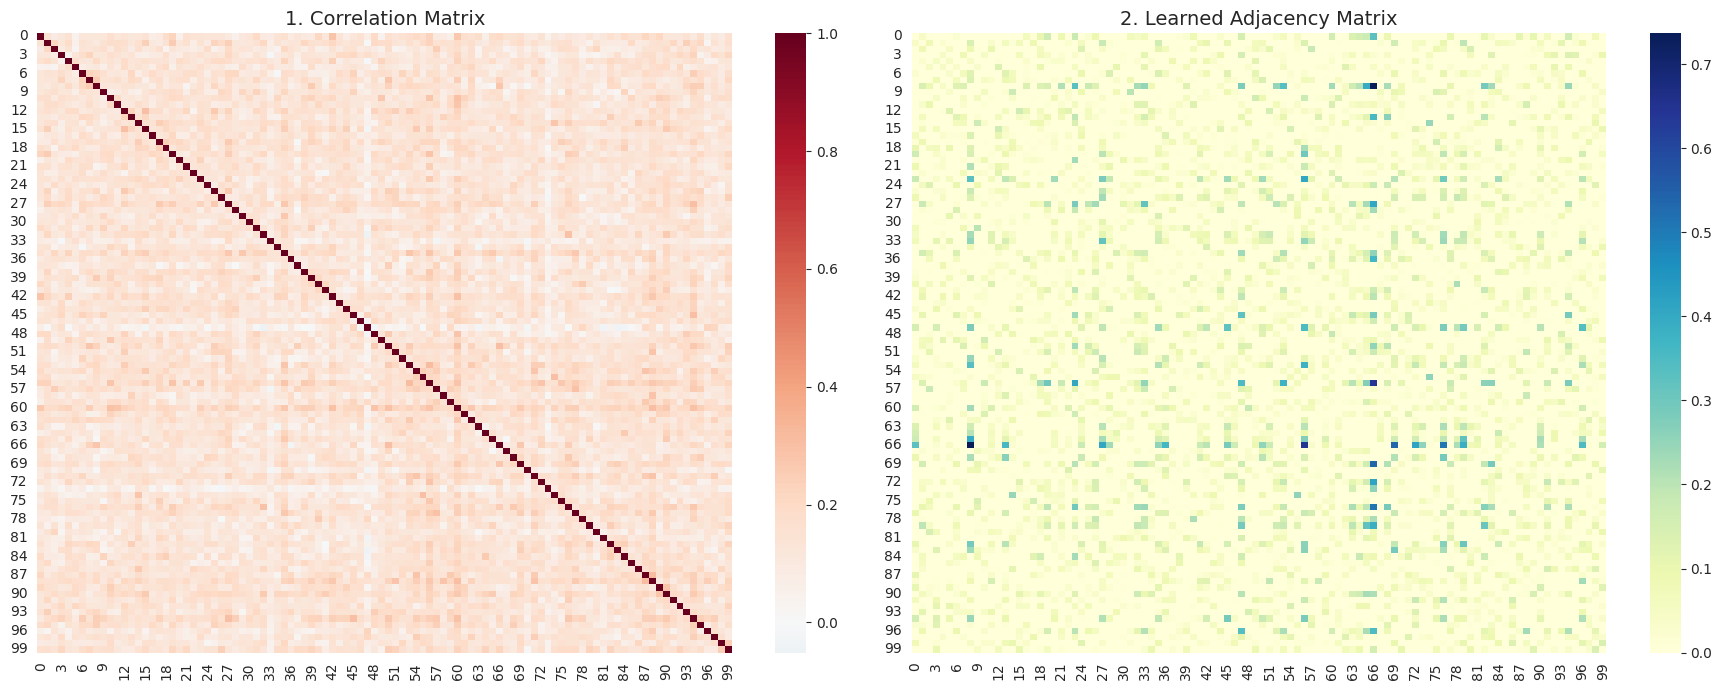

Number of edges retained: 1890 out of 4950


In [ ]:
# Fit the SGA model on the regular correlation matrix
model = GraphLearningSGA(alpha=0.05, gamma=1e5, max_iter=100)
model.fit(S_full)

# Plot correlation matrix vs learned adjacency
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(S_full, ax=ax[0], cmap='RdBu_r', center=0, cbar=True)
ax[0].set_title("1. Correlation Matrix", fontsize=14)

sns.heatmap(model.A_, ax=ax[1], cmap='YlGnBu', cbar=True)
ax[1].set_title("2. Learned Adjacency Matrix", fontsize=14)

plt.tight_layout()
plt.show()

# count non-zero edges
n_edges = np.count_nonzero(model.w_ > 1e-4)
print(f"Number of edges retained: {n_edges} out of {len(model.w_)}")

### Visualization of bipartite station flows

This function visualizes the learned bipartite adjacency matrix on a geographic map of New York City using Folium.

Each station is represented by a circle marker whose size reflects the strength of its dominant flow (outgoing or incoming). Stations with stronger departures are shown in red, while stations with stronger arrivals are shown in blue.

Edges are drawn between stations when the corresponding bipartite weight exceeds a fixed threshold, highlighting the most significant mobility flows learned by the model.

In [ ]:
def map_bipartite_flows(model, top_stations, df_coords):
    """
    Creates a Folium map of top stations with outgoing/incoming flows
    based on the learned bipartite adjacency matrix.
    """
    n_stations = len(top_stations)
    A = model.A_
    
    # Get unique station coordinates
    geo = df_coords.drop_duplicates('start_station_name').copy()
    geo_map = geo.set_index('start_station_name')[['start_lat', 'start_lng']].T.to_dict('list')
    
    # Initialize map centered on NYC
    m = folium.Map(location=[40.73, -73.94], zoom_start=13, tiles='cartodbpositron')

    # Draw station markers
    for i, name in enumerate(top_stations):
        if name in geo_map:
            pos = geo_map[name]
            
            # Outgoing and incoming weights
            out_weight = A[i, n_stations:].sum()
            in_weight = A[:n_stations, n_stations + i].sum()

            # Determine dominant type
            if out_weight >= in_weight:
                main_weight = out_weight
                color = '#E74C3C'  # Red for departure
                label = "Departure"
            else:
                main_weight = in_weight
                color = '#3498DB'  # Blue for arrival
                label = "Arrival"

            folium.CircleMarker(
                location=pos,
                radius=min(25, 5 + main_weight * 30),
                color=color,
                fill=True,
                fill_opacity=0.6,
                popup=f"<b>{name}</b><br>Dominant type: {label}<br>Strength: {main_weight:.3f}"
            ).add_to(m)

    # Draw edges for significant flows
    for i in range(n_stations):
        for j in range(n_stations):
            weight = A[i, n_stations + j]
            if weight > 0.08:
                start_st, end_st = top_stations[i], top_stations[j]
                if start_st in geo_map and end_st in geo_map:
                    folium.PolyLine(
                        locations=[geo_map[start_st], geo_map[end_st]],
                        color='#7F8C8D',
                        weight=1,
                        opacity=0.2,
                        tooltip=f"Flow: {start_st} -> {end_st}"
                    ).add_to(m)

    return m

In [ ]:
# Display the map
map_biparti = map_bipartite_flows(model, stations, df_raw)
map_biparti

### Time-dependent station activity visualization

This function visualizes station activity for a specific hourly time window using the Citi Bike dataset.

For each selected station, the total number of departures and arrivals during the chosen time slot is computed. Stations are displayed on a map with circle markers whose size reflects the activity level and whose color indicates whether departures or arrivals are dominant.

This allows us to analyze how station usage patterns vary throughout the day and to identify temporal mobility hotspots.

In [ ]:
def map_stations_by_time(df, top_stations, start_hour, end_hour):
    """
    Creates a Folium map for a specific hourly time window.
    
    Args:
        df: DataFrame containing 'started_at', 'start_station_name', 
            'end_station_name', 'start_lat', 'start_lng'
        top_stations: list of stations to visualize
        start_hour: integer, starting hour (inclusive)
        end_hour: integer, ending hour (exclusive)
    
    Returns:
        folium.Map object with station markers sized by activity.
    """
    
    # Ensure datetime and filter the selected time slot
    df['started_at'] = pd.to_datetime(df['started_at'])
    mask = (df['started_at'].dt.hour >= start_hour) & (df['started_at'].dt.hour < end_hour)
    df_slot = df[mask].copy()

    # Initialize map
    m = folium.Map(location=[40.73, -73.94], zoom_start=13, tiles='cartodbpositron')
    
    # Get unique station coordinates
    geo_map = df.drop_duplicates('start_station_name') \
                .set_index('start_station_name')[['start_lat', 'start_lng']].T.to_dict('list')

    for name in top_stations:
        if name in geo_map:
            pos = geo_map[name]
            
            # Count departures and arrivals in this slot
            out_weight = len(df_slot[df_slot['start_station_name'] == name])
            in_weight = len(df_slot[df_slot['end_station_name'] == name])
            
            total_activity = out_weight + in_weight
            if total_activity == 0:
                continue  # Skip stations with no activity

            # Determine dominant type
            if out_weight >= in_weight:
                color = '#E74C3C'  # Red for departures
                label = "Departure"
                force = out_weight
            else:
                color = '#3498DB'  # Blue for arrivals
                label = "Arrival"
                force = in_weight

            # Dynamic radius (sqrt scaling to prevent huge circles)
            radius_size = np.sqrt(force) * 2

            folium.CircleMarker(
                location=pos,
                radius=min(30, max(5, radius_size)),
                color=color,
                fill=True,
                fill_opacity=0.6,
                popup=f"<b>{name}</b><br>Slot: {start_hour}h-{end_hour}h<br>"
                      f"Dominance: {label}<br>Flow: {force} bikes"
            ).add_to(m)

    return m

The 18h–20h time window corresponds to evening commute hours. We expect to observe increased activity at major stations, with arrivals dominating in residential areas and departures dominating near business districts and transit hubs. Larger markers reflect higher demand, revealing clear spatial patterns in evening mobility.

In [ ]:
# visualize evening flows (18h - 20h)
map_evening = map_stations_by_time(df_raw, stations, 18, 20)
map_evening

The map shows clear evening commute patterns. Stations dominated by departures (red) are mostly located in central and business areas, while stations dominated by arrivals (blue) are more prevalent in residential or mixed-use neighborhoods. Larger markers indicate higher activity during this peak period, revealing a strong directional structure in evening mobility flows.